In [5]:
library(dplyr)
library(tidyr)
library(glmnet)
library(boot)
library(caret)
library(pls)
library(randomForest)
library(ROCR)
library(ggplot2)
library(corrplot)
library(pheatmap)
library(RColorBrewer)
library(viridis)


Attaching package: 'dplyr'


The following object is masked from 'package:nlme':

    collapse


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: Matrix


Attaching package: 'Matrix'


The following objects are masked from 'package:tidyr':

    expand, pack, unpack


Loaded glmnet 4.1-8

Loading required package: ggplot2

Loading required package: lattice


Attaching package: 'lattice'


The following object is masked from 'package:boot':

    melanoma



Attaching package: 'pls'


The following object is masked from 'package:caret':

    R2


The following object is masked from 'package:stats':

    loadings


randomForest 4.7-1.2

Type rfNews() to see new features/changes/bug fixes.


Attaching package: 'randomForest'


The following object is masked from 'package:ggplot2':

    margin


The following object is masked from 'package:dplyr

# Load and clean data

In [142]:
df1 <- data.table::fread("TDBRAIN_participants_demographics_cleaned.csv")
dim(df1)

df <- data.table::fread("merged_eeg_demographics.csv")
df <- df %>%
  filter(treatment_response != "")
dim(df)

[1] 252  58

[1] 164 689

In [7]:
## variables
outcome = "Responder"

demographics <- c("age", "gender", "education", "nrSessions", "cigarette_cat", 
                "coffee_cat", "beer_cat", "drugs_cat", "sleep", "well", "meal")

conditions <- c("condition", "duration_sec", "sampling_rate")

eeg_features <- df %>%
  select(starts_with("Fp1"), starts_with("Fp2"), starts_with("F3"), starts_with("F4"), 
      starts_with("Fz"), starts_with("Cz"), starts_with("C3"), starts_with("C4"), 
      contains("theta"), contains("alpha"), contains("fooof")) %>% 
  colnames() %>%
  unique()

oddball <- c("avg_rt_oddb_CP", "avg_rt_oddb_FP", "n_oddb_CP", "n_oddb_FP", 
      "n_oddb_CN", "n_oddb_FN", "oddball_accuracy")

In [8]:
predictors <- c(demographics, conditions, eeg_features, oddball) %>% unlist()
outcome <- "Responder"

In [9]:
# Select those columns
model_df <- df %>% 
    select(predictors, outcome) %>% 
    mutate(cigarette_cat = as.factor(cigarette_cat),
           coffee_cat = as.factor(coffee_cat),
           beer_cat = as.factor(beer_cat),
           drugs_cat = as.factor(drugs_cat),
           condition = as.factor(condition))

# Clean the data
model_df <- model_df %>%
  filter(!is.na(get(outcome))) %>%
  filter(rowSums(is.na(.)) < ncol(.))

Warning message:
"Using an external vector in selections was deprecated in tidyselect 1.1.0.
i Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(predictors)

  # Now:
  data %>% select(all_of(predictors))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>."
Warning message:
"Using an external vector in selections was deprecated in tidyselect 1.1.0.
i Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(outcome)

  # Now:
  data %>% select(all_of(outcome))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>."


In [10]:
factor_cols <- c("cigarette_cat", "coffee_cat", "beer_cat", "drugs_cat", "condition")
for(col in factor_cols) {
  if(col %in% names(model_df)) {
    model_df[[col]] <- droplevels(as.factor(model_df[[col]]))
    
    if(nlevels(model_df[[col]]) <= 1) {
      cat("Warning:", col, "has only", nlevels(model_df[[col]]), "level(s). Removing.\n")
      model_df[[col]] <- NULL
      predictors <- setdiff(predictors, col)
    }
  }
}

predictors_to_remove <- c()
for(col in predictors) {
  if(col %in% names(model_df)) {
    # Check if column exists and handle different data types
    if(is.numeric(model_df[[col]])) {
      col_var <- var(model_df[[col]], na.rm = TRUE)
      if(is.na(col_var) || col_var == 0 || all(is.na(model_df[[col]]))) {
        cat("Warning:", col, "has no variation or all NAs. Removing.\n")
        predictors_to_remove <- c(predictors_to_remove, col)
      }
    } else if(is.factor(model_df[[col]])) {
      # For factors, check number of levels
      if(nlevels(model_df[[col]]) <= 1) {
        cat("Warning:", col, "is a factor with", nlevels(model_df[[col]]), "level(s). Removing.\n")
        predictors_to_remove <- c(predictors_to_remove, col)
      }
    } else if(is.character(model_df[[col]])) {
      # For character columns, check unique values
      unique_vals <- length(unique(model_df[[col]][!is.na(model_df[[col]])]))
      if(unique_vals <= 1) {
        cat("Warning:", col, "is character with", unique_vals, "unique value(s). Removing.\n")
        predictors_to_remove <- c(predictors_to_remove, col)
      } else {
        # Convert to factor if it should be categorical
        model_df[[col]] <- as.factor(model_df[[col]])
      }
    }
  } else {
    cat("Warning:", col, "not found in data. Removing.\n")
    predictors_to_remove <- c(predictors_to_remove, col)
  }
}

# Remove problematic predictors
predictors <- setdiff(predictors, predictors_to_remove)
model_df <- model_df[, c(predictors, outcome), with = FALSE]

cat("Final number of predictors:", length(predictors), "\n")
cat("Final data dimensions:", nrow(model_df), "x", ncol(model_df), "\n")

Final number of predictors: 445 
Final data dimensions: 160 x 446 


In [11]:
# 1.1 Age Group Stratification
model_df <- model_df %>%
  mutate(age_group = case_when(
    age < 18 ~ "Child_Adolescent",
    age >= 18 & age < 35 ~ "Young_Adult", 
    age >= 35 ~ "Adult"
  ))

In [12]:
# 1.2 Descriptive Statistics by Age Group
demographic_summary <- model_df %>%
  group_by(age_group, Responder) %>%
  summarise(
    n = n(),
    mean_age = mean(age, na.rm = TRUE),
    prop_male = mean(gender == 1, na.rm = TRUE),
    mean_sessions = mean(nrSessions, na.rm = TRUE),
    .groups = 'drop'
  )

print(demographic_summary)
table(df$Responder)

# A tibble: 7 x 6
  age_group        Responder     n mean_age prop_male mean_sessions
  <chr>                <dbl> <int>    <dbl>     <dbl>         <dbl>
1 Adult                    0     2    36.0      1              1   
2 Adult                    1    50    42.9      0.52           1.32
3 Child_Adolescent         0    14     9.94     0.571          1   
4 Child_Adolescent         1    42    11.4      0.905          1.19
5 Young_Adult              0     2    23.8      0              1   
6 Young_Adult              1    46    26.8      0.391          1.17
7 NA                       1     4   NaN        0              2   



  0   1 
 18 142 

Removing 226 highly correlated features:
  [1] "Fp1_low_beta_abs"             "Fp1_fooof_exponent"          
  [3] "Fp1_fooof_alpha_pw"           "Fp2_theta_abs"               
  [5] "Fp2_alpha_rel"                "Fp2_low_beta_abs"            
  [7] "Fp2_low_beta_rel"             "Fp2_gamma_rel"               
  [9] "Fp2_alpha_peak_power"         "Fp2_fooof_exponent"          
 [11] "Fp2_fooof_alpha_cf"           "Fp2_fooof_alpha_pw"          
 [13] "F3_theta_abs"                 "F3_alpha_abs"                
 [15] "F3_low_beta_abs"              "F3_alpha_peak_power"         
 [17] "F3_fooof_exponent"            "F3_fooof_alpha_pw"           
 [19] "F4_theta_rel"                 "F4_alpha_abs"                
 [21] "F4_alpha_rel"                 "F4_low_beta_abs"             
 [23] "F4_gamma_abs"                 "F4_alpha_peak_power"         
 [25] "Fz_total_power"               "Fz_delta_abs"                
 [27] "Fz_delta_rel"                 "Fz_theta_abs"                
 [29] "

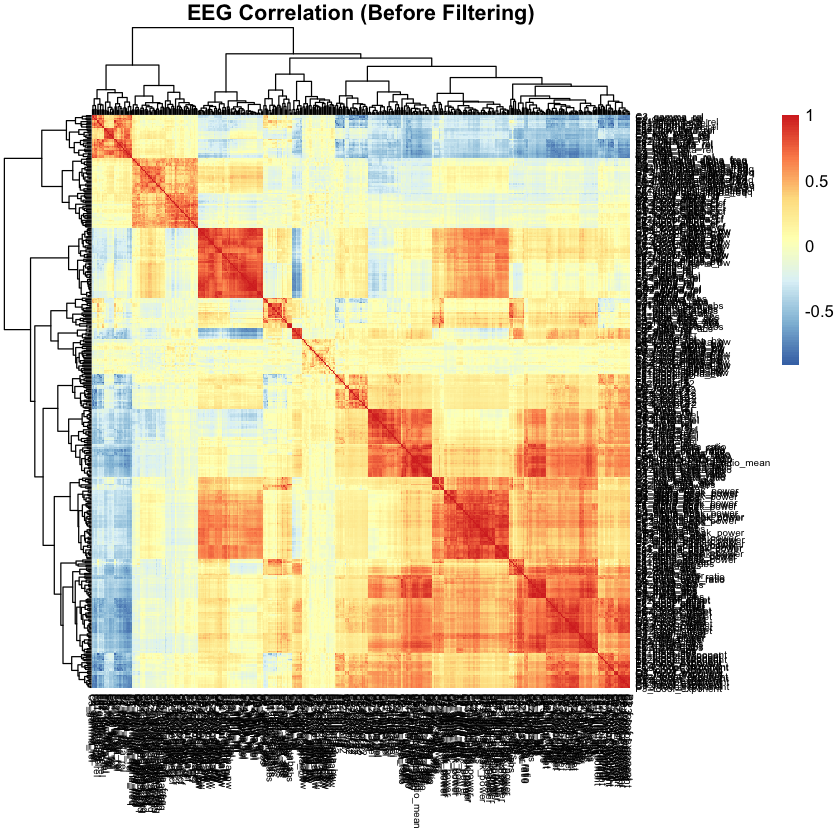

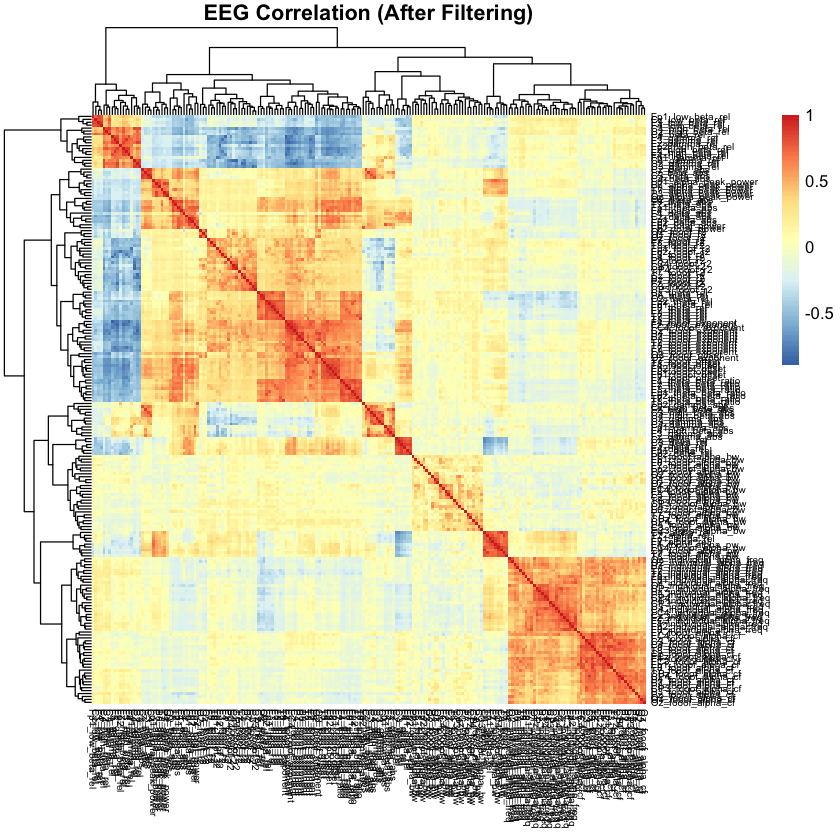

In [13]:
# 1.3 EEG Feature Correlation Analysis
eeg_cols <- grep("Fp1|Fp2|F3|F4|Fz|Cz|C3|C4|theta|alpha|fooof", names(model_df), value = TRUE)
cor_matrix <- cor(model_df[, eeg_cols, with = FALSE], use = "pairwise.complete.obs")

# Heatmap BEFORE removing highly correlated features
pheatmap(cor_matrix, main = "EEG Correlation (Before Filtering)", fontsize_row = 6, fontsize_col = 6)

# Remove highly correlated features (r > 0.9)
high_cor <- findCorrelation(cor_matrix, cutoff = 0.9, names = TRUE)
cat("Removing", length(high_cor), "highly correlated features:\n")
print(high_cor)

# Update predictors list
eeg_features_filtered <- setdiff(eeg_cols, high_cor)
predictors_final <- c(demographics, conditions, eeg_features_filtered, oddball)
predictors_final <- intersect(predictors_final, names(model_df))

# Heatmap AFTER removing highly correlated features
cor_matrix_filtered <- cor(model_df[, eeg_features_filtered, with = FALSE], use = "pairwise.complete.obs")
pheatmap(cor_matrix_filtered, main = "EEG Correlation (After Filtering)", fontsize_row = 6, fontsize_col = 6)

In [14]:
full_data <- model_df
cat("Full dataset size:", nrow(full_data), "\n")
cat("Number of predictors:", length(predictors_final), "\n")
cat("Response distribution:\n")
table(full_data$age_group, full_data$Responder)

Full dataset size: 160 
Number of predictors: 219 
Response distribution:


                  
                    0  1
  Adult             2 50
  Child_Adolescent 14 42
  Young_Adult       2 46

#  Random forest feature selection

In [15]:
# Function to perform imputation (compatible with data.table and data.frame)
perform_imputation <- function(data, response_col, method = "median") {
  # Convert to data.frame if it's a data.table to avoid column selection issues
  if ("data.table" %in% class(data)) {
    imputed_data <- as.data.frame(data)
  } else {
    imputed_data <- data
  }
  
  # Get predictor column names (exclude response)
  predictor_cols <- setdiff(names(imputed_data), response_col)
  
  # Impute missing values for each predictor
  for (col in predictor_cols) {
    if (any(is.na(imputed_data[[col]]))) {
      if (is.numeric(imputed_data[[col]])) {
        if (method == "mean") {
          replacement_val <- mean(imputed_data[[col]], na.rm = TRUE)
        } else {
          replacement_val <- median(imputed_data[[col]], na.rm = TRUE)
        }
        imputed_data[[col]][is.na(imputed_data[[col]])] <- replacement_val
      } else if (is.factor(imputed_data[[col]]) || is.character(imputed_data[[col]])) {
        # For categorical variables, use mode (most frequent value)
        freq_table <- table(imputed_data[[col]])
        if (length(freq_table) > 0) {
          mode_val <- names(sort(freq_table, decreasing = TRUE))[1]
          imputed_data[[col]][is.na(imputed_data[[col]])] <- mode_val
        }
      }
    }
  }
  
  return(imputed_data)
}

In [16]:
rf_feature_selection <- function(data, response_col, n_features = c(5,10), 
                                n_bootstrap = 100, imputation_method = "median") {
  
  library(randomForest)
  library(ROCR)
  library(dplyr)
  
  # Convert response to factor if not already
  y_original <- data[[response_col]]
  if (!is.factor(y_original)) {
    y_original <- as.factor(y_original)
  }
  
  # Store results for different numbers of features
  feature_performance <- data.frame()
  
  for (n_feat in n_features) {
    cat("Testing with", n_feat, "features...\n")
    
    bootstrap_aucs <- numeric(n_bootstrap)
    
    for (i in 1:n_bootstrap) {
      tryCatch({
        # Bootstrap sample
        boot_indices <- sample(nrow(data), replace = TRUE)
        boot_data <- data[boot_indices, ]
        
        # Impute missing values in bootstrap sample
        boot_data_imputed <- perform_imputation(boot_data, response_col, imputation_method)
        
        # Get predictor columns (exclude response)
        predictor_cols <- setdiff(names(boot_data_imputed), response_col)
        
        # Check if we have enough predictors
        if (length(predictor_cols) < n_feat) {
          cat("Warning: Only", length(predictor_cols), "predictors available, but", n_feat, "requested\n")
          next
        }
        
        # Prepare data for randomForest - FIXED: proper column selection
        X_boot <- boot_data_imputed[, predictor_cols, drop = FALSE]
        y_boot <- as.factor(boot_data_imputed[[response_col]])
        
        # Check for constant columns or insufficient data
        non_constant_cols <- sapply(X_boot, function(x) {
          if (is.numeric(x)) {
            return(var(x, na.rm = TRUE) > 0)
          } else {
            return(length(unique(x[!is.na(x)])) > 1)
          }
        })
        
        X_boot <- X_boot[, non_constant_cols, drop = FALSE]
        
        if (ncol(X_boot) < n_feat) {
          cat("Warning: Only", ncol(X_boot), "non-constant predictors available\n")
          next
        }
        
        # Fit RF to get variable importance
        rf_importance <- randomForest(
          x = X_boot, 
          y = y_boot,
          ntree = 500,
          importance = TRUE,
          na.action = na.omit  # Handle any remaining NAs
        )
        
        # Select top n_feat features based on Mean Decrease Gini
        importance_scores <- importance(rf_importance)[, "MeanDecreaseGini"]
        selected_features <- names(sort(importance_scores, decreasing = TRUE)[1:n_feat])
        
        # Impute original data for prediction
        original_data_imputed <- perform_imputation(data, response_col, imputation_method)
        
        # Prepare selected features from original data
        X_selected <- original_data_imputed[, selected_features, drop = FALSE]
        
        # Fit final RF model with selected features on bootstrap sample
        rf_final <- randomForest(
          x = boot_data_imputed[, selected_features, drop = FALSE], 
          y = as.factor(boot_data_imputed[[response_col]]),
          ntree = 500,
          na.action = na.omit
        )
        
        # Predict on imputed original dataset
        pred_prob <- predict(rf_final, newdata = X_selected, type = "prob")
        
        # Handle case where prediction might not have both classes
        if ("1" %in% colnames(pred_prob)) {
          pred_prob_1 <- pred_prob[, "1"]
        } else if (ncol(pred_prob) == 2) {
          pred_prob_1 <- pred_prob[, 2]  # Take second column if "1" not available
        } else {
          pred_prob_1 <- pred_prob[, 1]  # Single column case
        }
        
        # Calculate AUC
        pred_obj <- prediction(pred_prob_1, y_original)
        auc <- performance(pred_obj, "auc")@y.values[[1]]
        bootstrap_aucs[i] <- auc
        
      }, error = function(e) {
        cat("Error in bootstrap iteration", i, "for", n_feat, "features:", e$message, "\n")
        bootstrap_aucs[i] <- NA
      })
    }
    
    # Store results
    valid_aucs <- bootstrap_aucs[!is.na(bootstrap_aucs)]
    if (length(valid_aucs) > 0) {
      feature_performance <- rbind(feature_performance, data.frame(
        n_features = n_feat,
        mean_auc = mean(valid_aucs),
        sd_auc = sd(valid_aucs),
        median_auc = median(valid_aucs),
        q25_auc = quantile(valid_aucs, 0.25),
        q75_auc = quantile(valid_aucs, 0.75),
        n_valid = length(valid_aucs)
      ))
    }
  }
  
  return(feature_performance)
}

In [17]:
# Your dataset setup
full_data <- model_df
cat("Full dataset size:", nrow(full_data), "\n")
cat("Number of predictors:", length(predictors_final), "\n")
cat("Response distribution:\n")
print(table(full_data$age_group, full_data$Responder))

# Create analysis dataset with only the selected predictors and response
# Convert to data.frame if it's a data.table
if ("data.table" %in% class(full_data)) {
  analysis_data <- as.data.frame(full_data[, c(predictors_final, "Responder"), with = FALSE])
} else {
  analysis_data <- full_data[, c(predictors_final, "Responder")]
}
cat("\nAnalysis dataset dimensions:", dim(analysis_data), "\n")
cat("Analysis dataset class:", class(analysis_data), "\n")

# Check for missing data patterns
cat("Missing data summary:\n")
missing_summary <- colSums(is.na(analysis_data))
cat("Variables with missing data:", sum(missing_summary > 0), "\n")
cat("Total missing values:", sum(missing_summary), "\n")
cat("Percentage missing overall:", round(sum(missing_summary) / (nrow(analysis_data) * ncol(analysis_data)) * 100, 2), "%\n")

if(any(missing_summary > 0)) {
  cat("\nTop 10 variables with most missing data:\n")
  missing_sorted <- sort(missing_summary[missing_summary > 0], decreasing = TRUE)
  print(head(missing_sorted, 10))
}

Full dataset size: 160 
Number of predictors: 219 
Response distribution:
                  
                    0  1
  Adult             2 50
  Child_Adolescent 14 42
  Young_Adult       2 46

Analysis dataset dimensions: 160 220 
Analysis dataset class: data.frame 
Missing data summary:
Variables with missing data: 58 
Total missing values: 1610 
Percentage missing overall: 4.57 %

Top 10 variables with most missing data:
 F8_fooof_alpha_cf  F8_fooof_alpha_bw  F7_fooof_alpha_cf  F7_fooof_alpha_bw 
                48                 48                 45                 45 
 T7_fooof_alpha_cf  T7_fooof_alpha_pw  T7_fooof_alpha_bw Fp2_fooof_alpha_bw 
                44                 44                 44                 43 
 F4_fooof_alpha_cf  F4_fooof_alpha_pw 
                43                 43 


Testing with 5 features...
Testing with 10 features...
Testing with 20 features...
Testing with 30 features...
Testing with 40 features...
Testing with 50 features...
Testing with 60 features...
Testing with 70 features...
Testing with 80 features...
Testing with 90 features...
Testing with 100 features...
Optimal number of features: 60 
Best mean AUC: 0.972 

Feature selection results (top 10):
      n_features  mean_auc     sd_auc median_auc   q25_auc   q75_auc n_valid
25%6          60 0.9717821 0.02158614  0.9763302 0.9603873 0.9877739     100
25%8          80 0.9694347 0.02282744  0.9709507 0.9559370 0.9861600     100
25%10        100 0.9680321 0.02521839  0.9745696 0.9589202 0.9840571     100
25%4          40 0.9672848 0.02324865  0.9721244 0.9565728 0.9845951     100
25%2          20 0.9664065 0.02936375  0.9754499 0.9508998 0.9883118     100
25%5          50 0.9654577 0.03119608  0.9740806 0.9545677 0.9878228     100
25%9          90 0.9648846 0.02951139  0.9734937 0.9513889 0.9

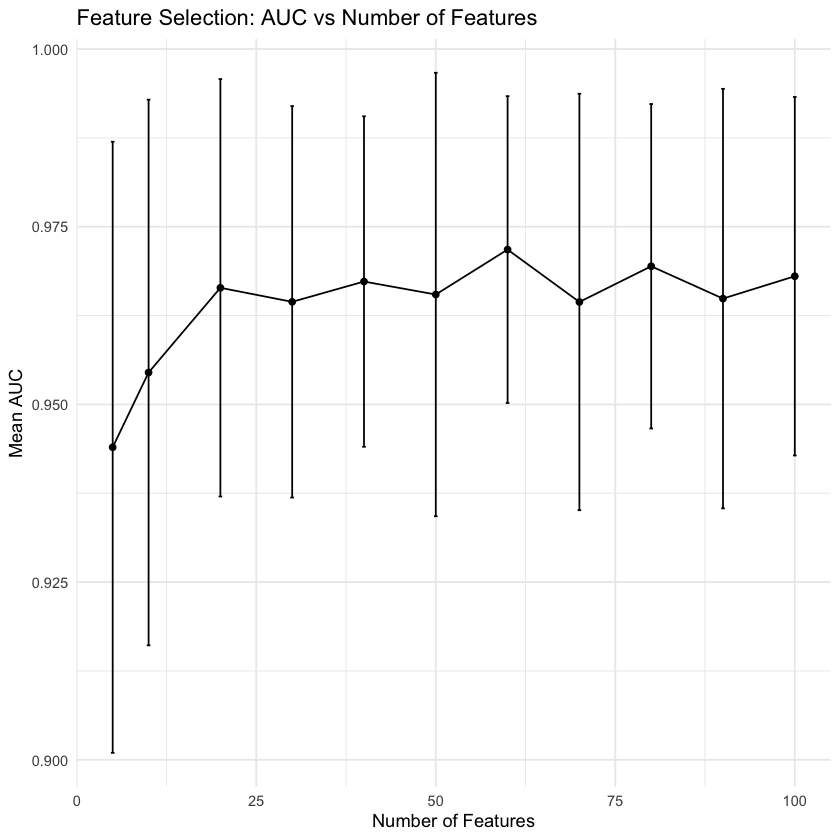

In [18]:
set.seed(227)

feature_results <- rf_feature_selection(
  data = analysis_data, 
  response_col = "Responder",
  n_features = c(5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100),
  n_bootstrap = 100,
  imputation_method = "median"  # or "mean"
)

p1 <- ggplot(feature_results, aes(x = n_features, y = mean_auc)) +
  geom_line() +
  geom_point() +
  geom_errorbar(aes(ymin = mean_auc - sd_auc, ymax = mean_auc + sd_auc), width = 0.5) +
  labs(title = "Feature Selection: AUC vs Number of Features",
       x = "Number of Features", y = "Mean AUC") +
  theme_minimal()
print(p1)

optimal_features <- feature_results$n_features[which.max(feature_results$mean_auc)]
cat("Optimal number of features:", optimal_features, "\n")
cat("Best mean AUC:", round(max(feature_results$mean_auc), 3), "\n")

cat("\nFeature selection results (top 10):\n")
print(head(feature_results[order(feature_results$mean_auc, decreasing = TRUE), ], 10))

# Random forest

In [ ]:
final_model_evaluation <- function(data, response_col, optimal_n_features, 
                                  n_bootstrap = 200, imputation_method = "median") {
  
  y_original <- data[[response_col]]
  if (!is.factor(y_original)) {
    y_original <- as.factor(y_original)
  }
  
  bootstrap_results <- list()
  final_aucs <- numeric(n_bootstrap)
  selected_features_list <- list()
  
  for (i in 1:n_bootstrap) {
    tryCatch({
      # Bootstrap sample
      boot_indices <- sample(nrow(data), replace = TRUE)
      boot_data <- data[boot_indices, ]
      
      # Impute missing values in bootstrap sample
      boot_data_imputed <- perform_imputation(boot_data, response_col, imputation_method)
      
      # Feature selection on bootstrap sample
      rf_importance <- randomForest(
        x = boot_data_imputed[, !names(boot_data_imputed) %in% response_col], 
        y = as.factor(boot_data_imputed[[response_col]]),
        ntree = 500,
        importance = TRUE,
        classwt = c("0" = 1, "1" = 1)
      )
      
      # Select optimal number of features
      importance_scores <- importance(rf_importance)[, "MeanDecreaseGini"]
      selected_features <- names(sort(importance_scores, decreasing = TRUE)[1:optimal_n_features])
      selected_features_list[[i]] <- selected_features
      
      # Final model with selected features
      rf_final <- randomForest(
        x = boot_data_imputed[, selected_features], 
        y = as.factor(boot_data_imputed[[response_col]]),
        ntree = 500,
        classwt = c("0" = 1, "1" = 1)
      )
      
      # Impute original data for prediction
      original_data_imputed <- perform_imputation(data, response_col, imputation_method)
      
      # Predict on imputed original dataset
      pred_prob <- predict(rf_final, newdata = original_data_imputed[, selected_features], type = "prob")[, "1"]
      
      # Calculate AUC
      pred_obj <- prediction(pred_prob, y_original)
      auc <- performance(pred_obj, "auc")@y.values[[1]]
      final_aucs[i] <- auc
      
      if (i %% 50 == 0) cat("Completed", i, "bootstrap iterations\n")
      
    }, error = function(e) {
      cat("Error in bootstrap iteration", i, ":", e$message, "\n")
      final_aucs[i] <- NA
    })
  }
  
  # Remove NA values
  valid_aucs <- final_aucs[!is.na(final_aucs)]
  valid_features <- selected_features_list[!is.na(final_aucs)]
  
  # Feature stability analysis
  all_features <- unlist(valid_features)
  feature_frequency <- table(all_features)
  feature_stability <- data.frame(
    feature = names(feature_frequency),
    selection_frequency = as.numeric(feature_frequency),
    selection_proportion = as.numeric(feature_frequency) / length(valid_features)
  ) %>% arrange(desc(selection_frequency))
  
  return(list(
    aucs = valid_aucs,
    mean_auc = mean(valid_aucs, na.rm = TRUE),
    sd_auc = sd(valid_aucs, na.rm = TRUE),
    ci_lower = quantile(valid_aucs, 0.025, na.rm = TRUE),
    ci_upper = quantile(valid_aucs, 0.975, na.rm = TRUE),
    feature_stability = feature_stability,
    selected_features_list = valid_features,
    n_valid_iterations = length(valid_aucs)
  ))
}

Completed 50 bootstrap iterations
Completed 100 bootstrap iterations
Completed 150 bootstrap iterations
Completed 200 bootstrap iterations
Completed 250 bootstrap iterations
Completed 300 bootstrap iterations
Completed 350 bootstrap iterations
Completed 400 bootstrap iterations
Completed 450 bootstrap iterations
Completed 500 bootstrap iterations
Completed 550 bootstrap iterations
Completed 600 bootstrap iterations
Completed 650 bootstrap iterations
Completed 700 bootstrap iterations
Completed 750 bootstrap iterations
Completed 800 bootstrap iterations
Completed 850 bootstrap iterations
Completed 900 bootstrap iterations
Completed 950 bootstrap iterations
Completed 1000 bootstrap iterations

=== FINAL RESULTS ===
Valid bootstrap iterations: 1000 out of 200
Mean AUC: 0.968 
SD AUC: 0.031 
95% CI: 0.869 - 0.998 

Top 10 most frequently selected features:
               feature selection_frequency selection_proportion
1     Cz_high_beta_rel                 966                0.966
2      

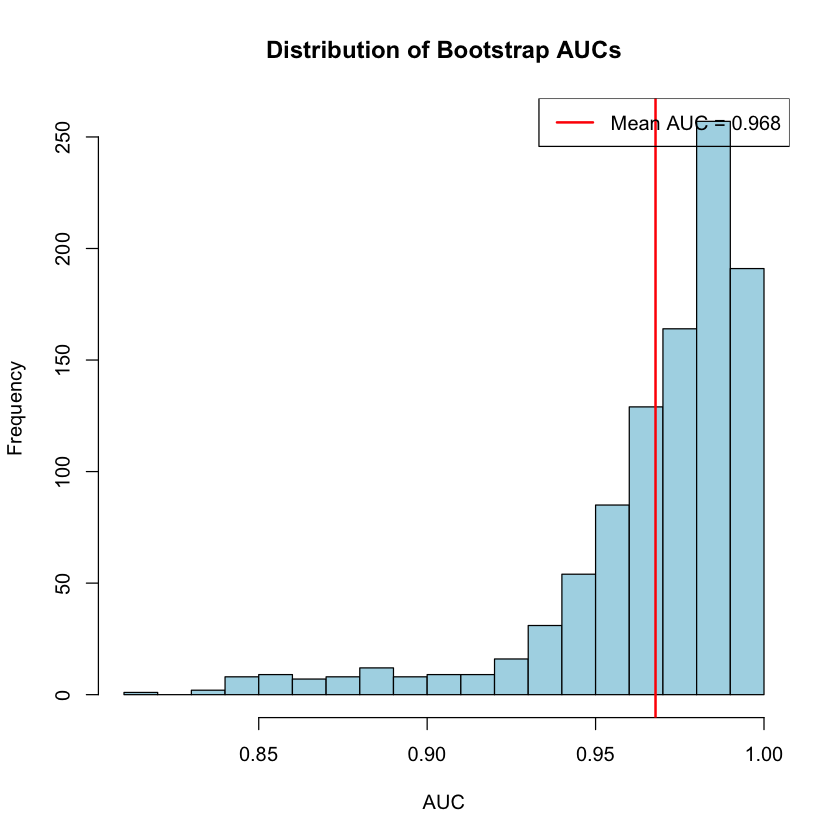


=== IMPUTATION SUMMARY ===
Method used: Median imputation for numeric variables, Mode for categorical
Imputation performed separately in each bootstrap iteration
This approach prevents data leakage and provides realistic performance estimates


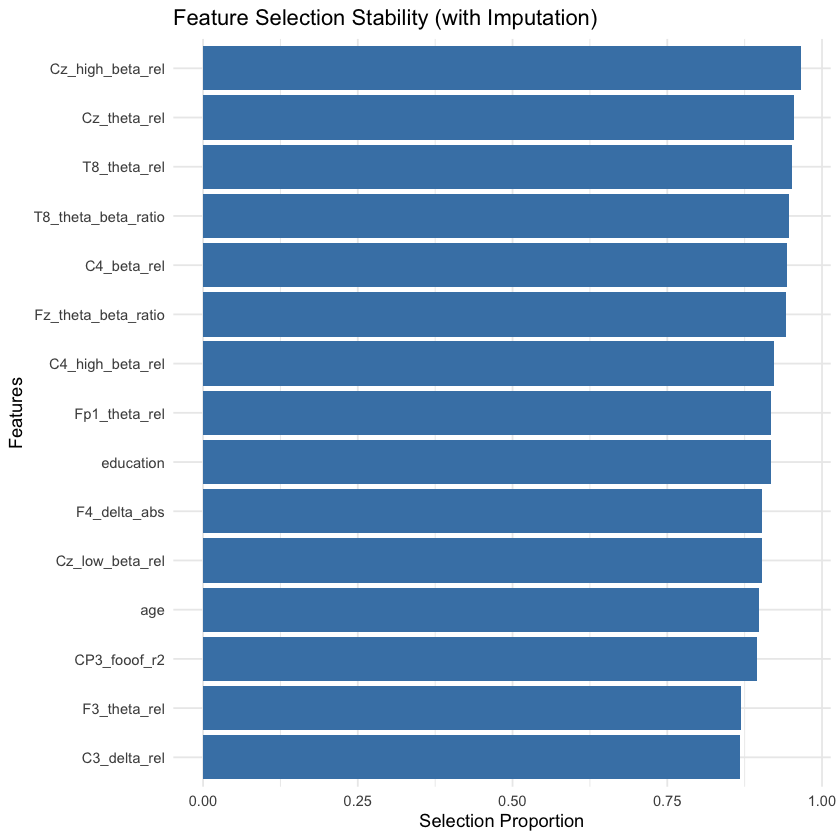

In [20]:
set.seed(624)

boot_final_results <- final_model_evaluation(
  data = analysis_data,
  response_col = "Responder", 
  optimal_n_features = 60,
  n_bootstrap = 1000,
  imputation_method = "median"  # Change to "mean" if preferred
)

# Print final results
cat("\n=== FINAL RESULTS ===\n")
cat("Valid bootstrap iterations:", boot_final_results$n_valid_iterations, "out of 200\n")
cat("Mean AUC:", round(boot_final_results$mean_auc, 3), "\n")
cat("SD AUC:", round(boot_final_results$sd_auc, 3), "\n")
cat("95% CI:", round(boot_final_results$ci_lower, 3), "-", round(boot_final_results$ci_upper, 3), "\n")

# Plot AUC distribution
hist(boot_final_results$aucs, breaks = 20, main = "Distribution of Bootstrap AUCs", 
     xlab = "AUC", col = "lightblue")
abline(v = boot_final_results$mean_auc, col = "red", lwd = 2)
legend("topright", paste("Mean AUC =", round(boot_final_results$mean_auc, 3)), 
       col = "red", lwd = 2)

# Feature stability (top 10 most frequently selected)
cat("\nTop 10 most frequently selected features:\n")
print(head(boot_final_results$feature_stability, 10))

# Plot feature stability
top_features <- head(boot_final_results$feature_stability, 15)
p2 <- ggplot(top_features, aes(x = reorder(feature, selection_proportion), y = selection_proportion)) +
  geom_bar(stat = "identity", fill = "steelblue") +
  coord_flip() +
  labs(title = "Feature Selection Stability (with Imputation)", 
       x = "Features", y = "Selection Proportion") +
  theme_minimal()
print(p2)

# Summary of imputation approach
cat("\n=== IMPUTATION SUMMARY ===\n")
cat("Method used: Median imputation for numeric variables, Mode for categorical\n")
cat("Imputation performed separately in each bootstrap iteration\n")
cat("This approach prevents data leakage and provides realistic performance estimates\n")

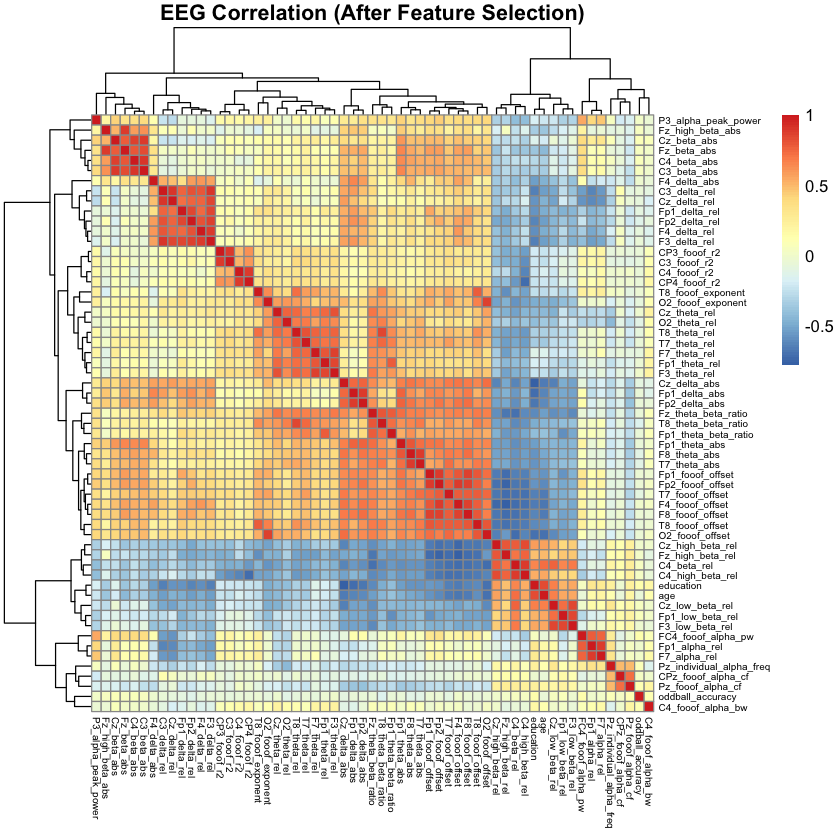

In [ ]:
# Heatmap AFTER removing highly correlated features
selected_features <- head(boot_final_results$feature_stability, 60) %>% pull(feature)

selected_numeric <- model_df %>%
  select(selected_features) %>%
  select(where(is.numeric))

cor_matrix_selected <- cor(selected_numeric, use = "pairwise.complete.obs")
pheatmap(cor_matrix_selected, main = "EEG Correlation (After Feature Selection)", fontsize_row = 6, fontsize_col = 6)

# Train final RF model

In [ ]:
top_60_features <- head(boot_final_results$feature_stability$feature, 60)

final_data <- perform_imputation(analysis_data, "Responder", "median")

final_rf_model <- randomForest(
  x = final_data[, top_60_features, drop = FALSE],
  y = as.factor(final_data$Responder),
  ntree = 1000,
  importance = TRUE
)

importance(final_rf_model)

,0,1,MeanDecreaseAccuracy,MeanDecreaseGini
Cz_high_beta_rel,6.11900380,4.214634,6.765573,1.3366511
Cz_theta_rel,5.27295445,4.410231,5.628931,0.6483298
T8_theta_rel,6.86112393,6.897446,8.384587,1.0554387
T8_theta_beta_ratio,5.99710949,7.927068,8.910646,0.9609694
C4_beta_rel,2.03052780,5.261185,5.815646,0.6055226
Fz_theta_beta_ratio,6.56012195,5.957937,8.034399,1.0700912
C4_high_beta_rel,1.71830222,4.967643,4.996817,0.3764241
Fp1_theta_rel,1.11290274,3.178904,3.317174,0.2711420
education,2.62159950,4.341494,4.859663,0.4519794
Cz_low_beta_rel,3.34204246,4.884966,5.569666,0.6561823


Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
i Please use `linewidth` instead."


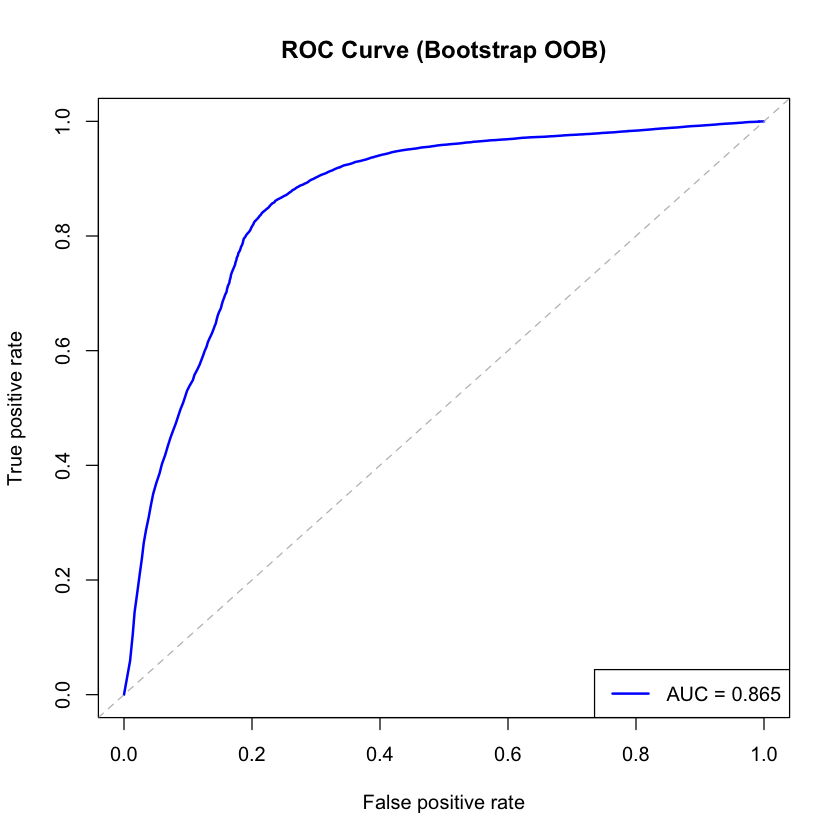

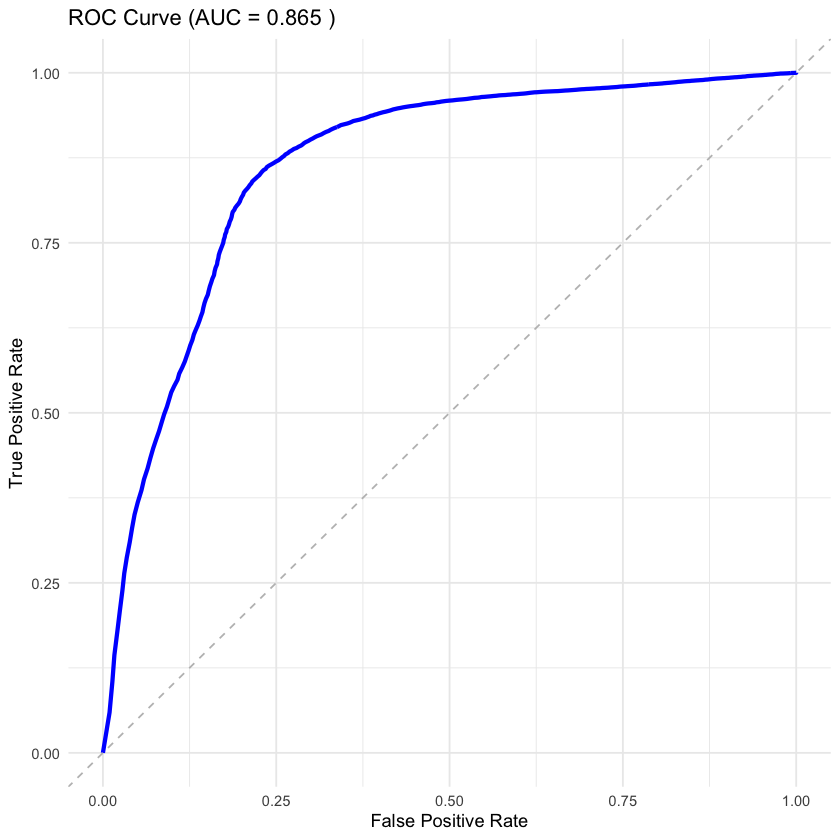

In [91]:
library(ROCR)
library(ggplot2)

# Collect all OOB predictions and true labels
all_probs <- c()
all_labels <- c()

set.seed(227)
n_bootstrap <- 1000

for (i in 1:n_bootstrap) {
  idx <- sample(nrow(final_data), replace = TRUE)
  train_data <- final_data[idx, ]
  test_idx <- setdiff(1:nrow(final_data), unique(idx))
  test_data <- final_data[test_idx, ]
  
  if (nrow(test_data) < 5) next
  
  rf <- randomForest(
    x = train_data[, top_60_features, drop = FALSE],
    y = as.factor(train_data$Responder),
    ntree = 500
  )
  
  prob <- predict(rf, newdata = test_data[, top_60_features, drop = FALSE], type = "prob")[, "1"]
  all_probs <- c(all_probs, prob)
  all_labels <- c(all_labels, test_data$Responder)
}

# Create ROCR prediction object
pred_obj <- prediction(all_probs, all_labels)
perf <- performance(pred_obj, "tpr", "fpr")

# Plot ROC curve
plot(perf, col = "blue", lwd = 2, main = "ROC Curve (Bootstrap OOB)")
abline(a = 0, b = 1, lty = 2, col = "gray")
auc <- performance(pred_obj, "auc")@y.values[[1]]
legend("bottomright", legend = paste("AUC =", round(auc, 3)), col = "blue", lwd = 2)

# Optionally, plot with ggplot2 for a nicer look
roc_df <- data.frame(
  fpr = perf@x.values[[1]],
  tpr = perf@y.values[[1]]
)

ggplot(roc_df, aes(x = fpr, y = tpr)) +
  geom_line(color = "blue", size = 1.2) +
  geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "gray") +
  labs(title = paste("ROC Curve (AUC =", round(auc, 3), ")"),
       x = "False Positive Rate", y = "True Positive Rate") +
  theme_minimal()

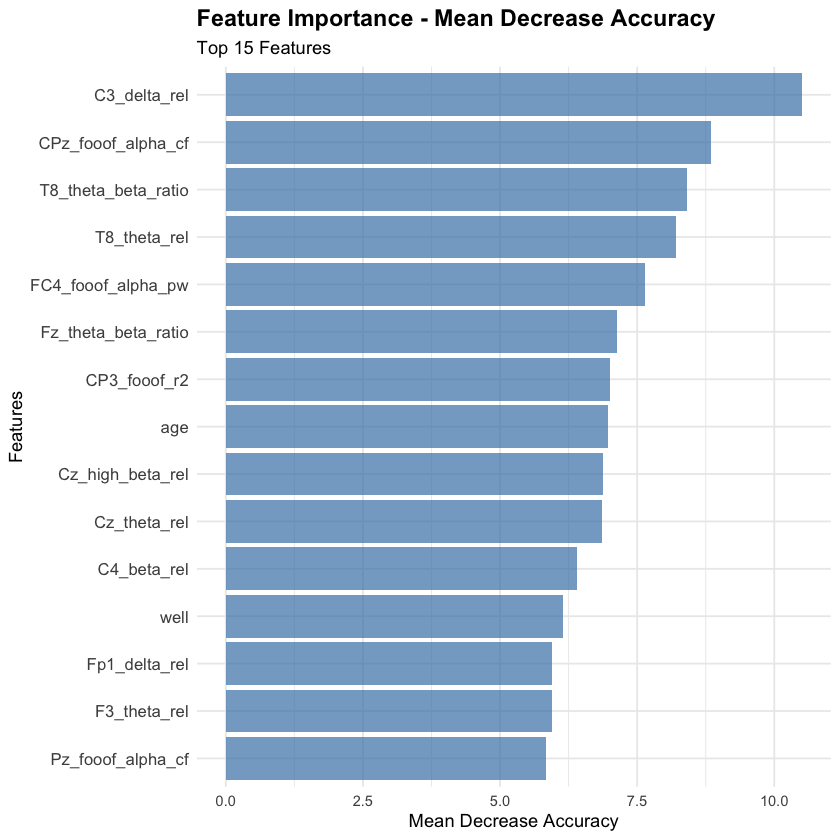


Attaching package: 'reshape2'


The following object is masked from 'package:tidyr':

    smiths




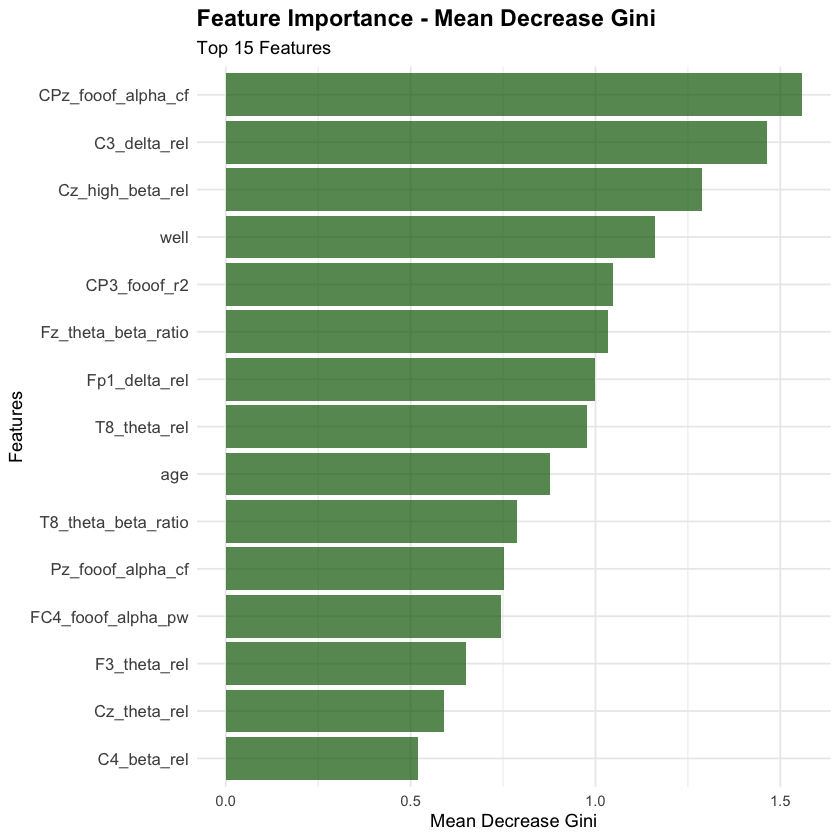

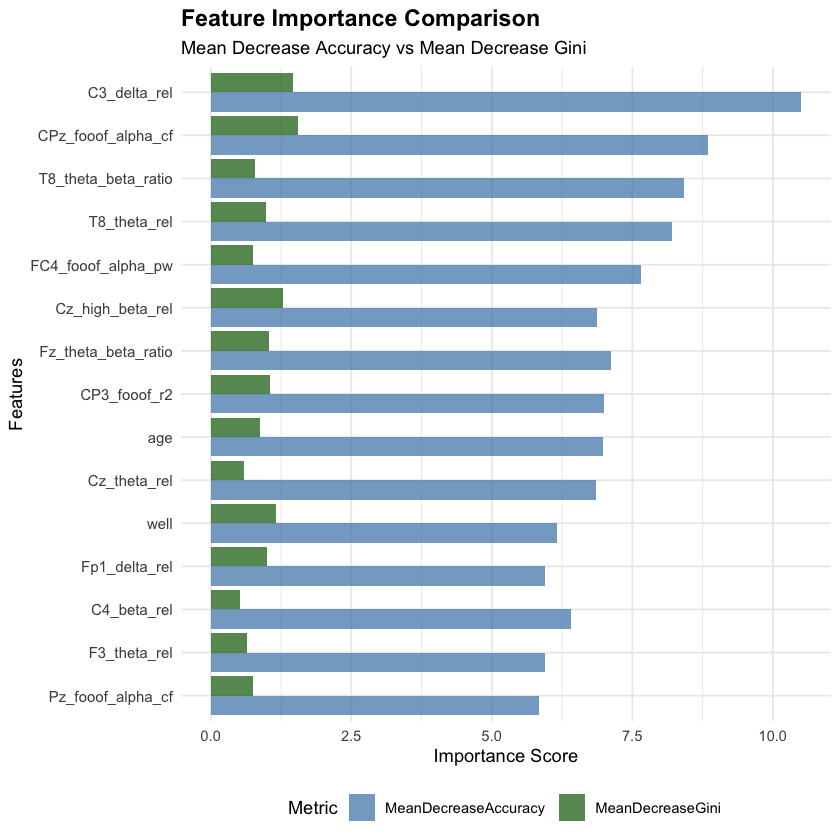

Model Performance Summary:
AUC: 0.865 
Number of bootstrap iterations: 1000 
Total OOB predictions: 58822 

Top 5 Most Important Features:
                                Feature MeanDecreaseAccuracy
C3_delta_rel               C3_delta_rel            10.506379
CPz_fooof_alpha_cf   CPz_fooof_alpha_cf             8.842010
T8_theta_beta_ratio T8_theta_beta_ratio             8.414394
T8_theta_rel               T8_theta_rel             8.208876
FC4_fooof_alpha_pw   FC4_fooof_alpha_pw             7.648504


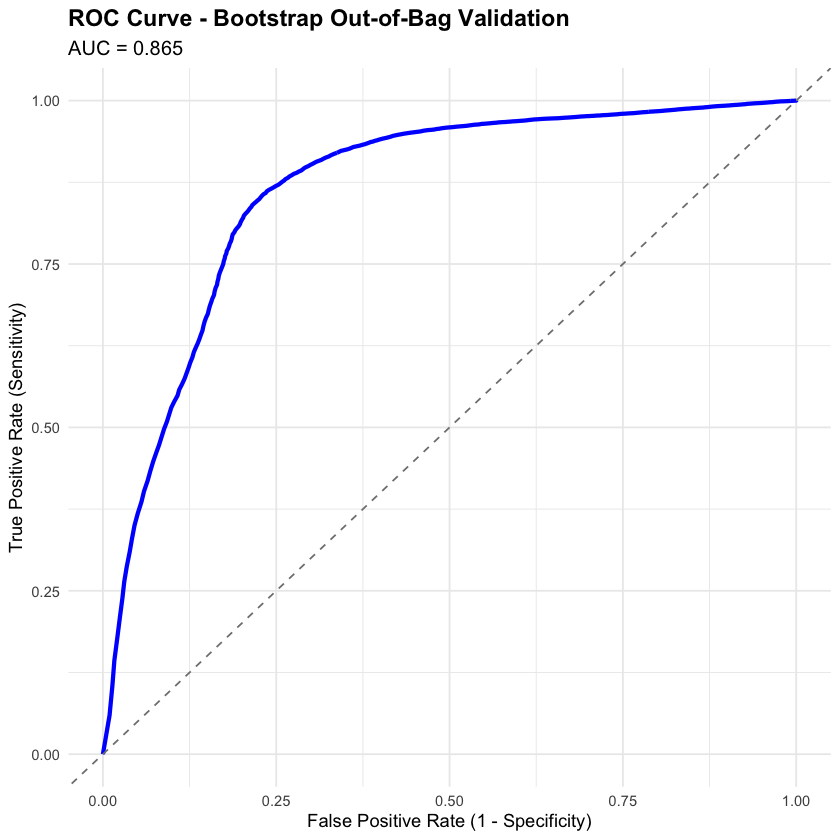

In [ ]:
# Extract feature importance
importance_scores <- importance(final_rf_model)

# Create feature importance plots
# 1. Feature Importance Bar Plot (Top 15 features)
importance_df <- data.frame(
  Feature = rownames(importance_scores),
  MeanDecreaseAccuracy = importance_scores[, "MeanDecreaseAccuracy"],
  MeanDecreaseGini = importance_scores[, "MeanDecreaseGini"]
)

# Sort by MeanDecreaseAccuracy and take top 15
top_features <- importance_df %>%
  arrange(desc(MeanDecreaseAccuracy)) %>%
  head(15)

# Plot 1: Mean Decrease Accuracy
p1 <- ggplot(top_features, aes(x = reorder(Feature, MeanDecreaseAccuracy), 
                               y = MeanDecreaseAccuracy)) +
  geom_col(fill = "steelblue", alpha = 0.7) +
  coord_flip() +
  labs(title = "Feature Importance - Mean Decrease Accuracy",
       subtitle = "Top 15 Features",
       x = "Features", 
       y = "Mean Decrease Accuracy") +
  theme_minimal() +
  theme(axis.text.y = element_text(size = 10),
        plot.title = element_text(size = 14, face = "bold"))

print(p1)

# Plot 2: Mean Decrease Gini
p2 <- ggplot(top_features, aes(x = reorder(Feature, MeanDecreaseGini), 
                               y = MeanDecreaseGini)) +
  geom_col(fill = "darkgreen", alpha = 0.7) +
  coord_flip() +
  labs(title = "Feature Importance - Mean Decrease Gini",
       subtitle = "Top 15 Features",
       x = "Features", 
       y = "Mean Decrease Gini") +
  theme_minimal() +
  theme(axis.text.y = element_text(size = 10),
        plot.title = element_text(size = 14, face = "bold"))

print(p2)

# Plot 3: Combined importance plot
library(reshape2)
top_features_long <- melt(top_features, 
                         id.vars = "Feature",
                         measure.vars = c("MeanDecreaseAccuracy", "MeanDecreaseGini"),
                         variable.name = "Metric",
                         value.name = "Importance")

p3 <- ggplot(top_features_long, aes(x = reorder(Feature, Importance), 
                                   y = Importance, 
                                   fill = Metric)) +
  geom_col(position = "dodge", alpha = 0.7) +
  coord_flip() +
  scale_fill_manual(values = c("steelblue", "darkgreen")) +
  labs(title = "Feature Importance Comparison",
       subtitle = "Mean Decrease Accuracy vs Mean Decrease Gini",
       x = "Features", 
       y = "Importance Score") +
  theme_minimal() +
  theme(axis.text.y = element_text(size = 9),
        plot.title = element_text(size = 14, face = "bold"),
        legend.position = "bottom")

print(p3)

# Your ROC curve code (improved)
set.seed(227)
n_bootstrap <- 1000
all_probs <- c()
all_labels <- c()

for (i in 1:n_bootstrap) {
  idx <- sample(nrow(final_data), replace = TRUE)
  train_data <- final_data[idx, ]
  test_idx <- setdiff(1:nrow(final_data), unique(idx))
  test_data <- final_data[test_idx, ]
  
  if (nrow(test_data) < 5) next
  
  rf <- randomForest(
    x = train_data[, top_60_features, drop = FALSE],
    y = as.factor(train_data$Responder),
    ntree = 500
  )
  
  prob <- predict(rf, newdata = test_data[, top_60_features, drop = FALSE], 
                  type = "prob")[, "1"]
  all_probs <- c(all_probs, prob)
  all_labels <- c(all_labels, test_data$Responder)
}

# Create ROCR prediction object
pred_obj <- prediction(all_probs, all_labels)
perf <- performance(pred_obj, "tpr", "fpr")
auc <- performance(pred_obj, "auc")@y.values[[1]]

# Enhanced ROC plot with ggplot2
roc_df <- data.frame(
  fpr = perf@x.values[[1]],
  tpr = perf@y.values[[1]]
)

p4 <- ggplot(roc_df, aes(x = fpr, y = tpr)) +
  geom_line(color = "blue", size = 1.2) +
  geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "gray50") +
  labs(title = "ROC Curve - Bootstrap Out-of-Bag Validation",
       subtitle = paste("AUC =", round(auc, 3)),
       x = "False Positive Rate (1 - Specificity)", 
       y = "True Positive Rate (Sensitivity)") +
  theme_minimal() +
  theme(plot.title = element_text(size = 14, face = "bold"),
        plot.subtitle = element_text(size = 12)) +
  xlim(0, 1) + ylim(0, 1)

print(p4)

# Print summary statistics
cat("Model Performance Summary:\n")
cat("AUC:", round(auc, 3), "\n")
cat("Number of bootstrap iterations:", n_bootstrap, "\n")
cat("Total OOB predictions:", length(all_probs), "\n")
cat("\nTop 5 Most Important Features:\n")
print(head(top_features[, c("Feature", "MeanDecreaseAccuracy")], 5))

# Optional: Save plots
# ggsave("feature_importance_accuracy.png", p1, width = 10, height = 8, dpi = 300)
# ggsave("feature_importance_gini.png", p2, width = 10, height = 8, dpi = 300)
# ggsave("feature_importance_combined.png", p3, width = 12, height = 8, dpi = 300)
# ggsave("roc_curve.png", p4, width = 8, height = 6, dpi = 300)

In [148]:
# Load required libraries
library(ggplot2)
library(dplyr)

# Extract your top 15 features by Mean Decrease Accuracy
importance_scores <- importance(final_rf_model)
importance_df <- data.frame(
  Feature = rownames(importance_scores),
  MeanDecreaseAccuracy = importance_scores[, "MeanDecreaseAccuracy"],
  MeanDecreaseGini = importance_scores[, "MeanDecreaseGini"]
)

top_15_features <- importance_df %>%
  arrange(desc(MeanDecreaseAccuracy)) %>%
  head(15) %>%
  pull(Feature)

# Function to extract electrode names from feature names
extract_electrode <- function(feature_name) {
  # Remove common suffixes like _rel, _abs, _high, _low, _beta, _theta, etc.
  electrode <- gsub("_(rel|abs|high|low|beta|theta|alpha|delta|gamma|ratio).*", "", feature_name)
  electrode <- gsub("_.*", "", electrode)  # Take everything before first underscore
  return(electrode)
}

# Extract electrode names from your top features
top_electrodes <- sapply(top_15_features, extract_electrode)
top_electrodes <- unique(top_electrodes[top_electrodes != "education"])  # Remove non-electrode features

# Standard 10-20 electrode positions (approximate coordinates)
electrode_positions <- data.frame(
  electrode = c("Fp1", "Fp2", "F3", "F4", "F7", "F8", "Fz", "C3", "C4", "Cz", 
                "P3", "P4", "Pz", "T3", "T4", "T5", "T6", "T7", "T8", "O1", "O2", "Oz"),
  x = c(-0.3, 0.3, -0.5, 0.5, -0.7, 0.7, 0, -0.5, 0.5, 0, 
        -0.5, 0.5, 0, -0.8, 0.8, -0.8, 0.8, -0.8, 0.8, -0.3, 0.3, 0),
  y = c(0.8, 0.8, 0.5, 0.5, 0.3, 0.3, 0.7, 0, 0, 0.2, 
        -0.5, -0.5, -0.3, 0, 0, -0.5, -0.5, 0, 0, -0.8, -0.8, -0.7)
)

# Add importance scores to electrode positions
electrode_positions$is_important <- electrode_positions$electrode %in% top_electrodes
electrode_positions$importance_rank <- NA

for(i in 1:length(top_electrodes)) {
  if(top_electrodes[i] %in% electrode_positions$electrode) {
    electrode_positions$importance_rank[electrode_positions$electrode == top_electrodes[i]] <- i
  }
}

# Create the brain map
p_brain <- ggplot(electrode_positions, aes(x = x, y = y)) +
  # Draw head outline (circle)
  geom_circle(aes(x0 = 0, y0 = 0, r = 1), 
              color = "black", size = 1.5, fill = NA, inherit.aes = FALSE) +
  # Draw nose (triangle at top)
  geom_polygon(data = data.frame(x = c(-0.1, 0.1, 0), y = c(1, 1, 1.2)), 
               fill = "white", color = "black", size = 1) +
  # Draw ears
  geom_arc(aes(x0 = -1, y0 = 0, r = 0.15, start = -pi/2, end = pi/2), 
           color = "black", size = 1, inherit.aes = FALSE) +
  geom_arc(aes(x0 = 1, y0 = 0, r = 0.15, start = pi/2, end = 3*pi/2), 
           color = "black", size = 1, inherit.aes = FALSE) +
  # Plot electrodes
  geom_point(aes(size = ifelse(is_important, 6, 3),
                 color = ifelse(is_important, "Important", "Other"),
                 alpha = ifelse(is_important, 1, 0.6))) +
  # Add electrode labels
  geom_text(aes(label = electrode), 
            vjust = -1.5, hjust = 0.5, size = 3, fontface = "bold") +
  # Customize colors and sizes
  scale_color_manual(values = c("Important" = "red", "Other" = "lightblue")) +
  scale_size_identity() +
  scale_alpha_identity() +
  # Set equal aspect ratio and remove axes
  coord_fixed(ratio = 1) +
  theme_void() +
  theme(legend.position = "bottom",
        plot.title = element_text(hjust = 0.5, size = 16, face = "bold"),
        plot.subtitle = element_text(hjust = 0.5, size = 12)) +
  labs(title = "EEG Electrode Importance Map",
       subtitle = paste("Top", length(top_electrodes), "Most Important Electrodes for Treatment Response Prediction"),
       color = "") +
  # Add directional labels
  annotate("text", x = 0, y = 1.4, label = "Front", size = 4, fontface = "bold") +
  annotate("text", x = 0, y = -1.4, label = "Back", size = 4, fontface = "bold") +
  annotate("text", x = -1.3, y = 0, label = "L", size = 4, fontface = "bold") +
  annotate("text", x = 1.3, y = 0, label = "R", size = 4, fontface = "bold")

# If you don't have ggforce for circles, use this alternative approach:
# Alternative brain map without ggforce
p_brain_alt <- ggplot(electrode_positions, aes(x = x, y = y)) +
  # Plot electrodes
  geom_point(aes(size = ifelse(is_important, 8, 4),
                 color = ifelse(is_important, "red", "lightblue"),
                 alpha = ifelse(is_important, 1, 0.6))) +
  # Add electrode labels
  geom_text(aes(label = electrode, 
                fontface = ifelse(is_important, "bold", "plain")), 
            vjust = -1.8, hjust = 0.5, size = 3.5) +
  # Highlight important electrodes with a ring
  geom_point(data = electrode_positions[electrode_positions$is_important, ],
             aes(x = x, y = y), 
             size = 10, shape = 1, color = "darkred", stroke = 2) +
  scale_size_identity() +
  scale_color_identity() +
  scale_alpha_identity() +
  coord_fixed(ratio = 1, xlim = c(-1.5, 1.5), ylim = c(-1.5, 1.5)) +
  theme_void() +
  theme(plot.title = element_text(hjust = 0.5, size = 16, face = "bold"),
        plot.subtitle = element_text(hjust = 0.5, size = 12)) +
  labs(title = "EEG Electrode Importance Map",
       subtitle = paste("Red electrodes are among top", length(top_electrodes), "most important for prediction")) +
  # Add directional labels
  annotate("text", x = 0, y = 1.3, label = "FRONT", size = 5, fontface = "bold") +
  annotate("text", x = 0, y = -1.3, label = "BACK", size = 5, fontface = "bold") +
  annotate("text", x = -1.3, y = 0, label = "L", size = 5, fontface = "bold") +
  annotate("text", x = 1.3, y = 0, label = "R", size = 5, fontface = "bold") +
  # Add a simple head outline using points
  geom_point(data = data.frame(
    x = cos(seq(0, 2*pi, length.out = 100)),
    y = sin(seq(0, 2*pi, length.out = 100))
  ), aes(x = x, y = y), size = 0.5, color = "black", alpha = 0.3)

print(p_brain_alt)

# Print which electrodes are highlighted
cat("Top important electrodes highlighted on the map:\n")
cat(paste(top_electrodes, collapse = ", "), "\n")

# Create a legend table
legend_df <- importance_df %>%
  filter(Feature %in% top_15_features) %>%
  mutate(Electrode = sapply(Feature, extract_electrode)) %>%
  filter(Electrode %in% top_electrodes) %>%
  arrange(desc(MeanDecreaseAccuracy)) %>%
  select(Electrode, Feature, MeanDecreaseAccuracy)

print("Electrode importance details:")
print(legend_df)

# Save the plot
# ggsave("electrode_importance_map.png", p_brain_alt, width = 10, height = 8, dpi = 300)

ERROR: Error in geom_circle(aes(x0 = 0, y0 = 0, r = 1), color = "black", size = 1.5, : could not find function "geom_circle"


# AGE-SPECIFIC ANALYSES

In [119]:
library(dplyr)
library(ggplot2)
library(randomForest)
library(ROCR)
library(corrplot)
library(pheatmap)
library(gridExtra)
library(RColorBrewer)

In [193]:
complete_coherent_age_analysis <- function(data, top_features, final_results, 
                                          existing_model = NULL, n_top_features = 60) {
  
  cat(strrep("=", 80), "\n")
  cat("COHERENT AGE ANALYSIS - COMPREHENSIVE RESULTS\n")
  cat(strrep("=", 80), "\n\n")
  
  # Prepare data and features
  eeg_features_only <- top_features[!grepl("age|education|gender|sessions", top_features, ignore.case = TRUE)]
  eeg_features_top <- head(eeg_features_only, n_top_features)
  
  # Remove any features not in data
  eeg_features_available <- intersect(eeg_features_top, names(data))
  
  cat("ANALYSIS SETUP:\n")
  cat("- Total participants:", nrow(data), "\n")
  cat("- Age range:", round(min(data$age, na.rm = TRUE), 1), "to", 
      round(max(data$age, na.rm = TRUE), 1), "years\n")
  cat("- Responders:", sum(data$Responder == 1), "\n")
  cat("- Non-responders:", sum(data$Responder == 0), "\n")
  cat("- EEG features analyzed:", length(eeg_features_available), "\n\n")
  
  # =========================================================================
  # ANALYSIS 1: AGE-STRATIFIED PERFORMANCE (NO NEW MODEL TRAINING)
  # =========================================================================
  
  cat("ANALYSIS 1: AGE-STRATIFIED PERFORMANCE\n")
  cat("=====================================\n")
  
  # Create age tertiles for comparison
  age_tertiles <- quantile(data$age, probs = c(0, 1/3, 2/3, 1), na.rm = TRUE)
  data$age_tertile <- cut(data$age, breaks = age_tertiles, 
                         labels = c("Youngest", "Middle", "Oldest"), include.lowest = TRUE)
  
  # Calculate sample sizes by age group
  age_breakdown <- data %>%
    group_by(age_tertile, Responder) %>%
    summarise(n = n(), .groups = 'drop') %>%
    tidyr::pivot_wider(names_from = Responder, values_from = n, 
                      names_prefix = "Response_", values_fill = 0) %>%
    mutate(
      Total = Response_0 + Response_1,
      Response_Rate = round(Response_1 / Total * 100, 1),
      Age_Range = case_when(
        age_tertile == "Youngest" ~ paste0(round(age_tertiles[1], 1), "-", round(age_tertiles[2], 1)),
        age_tertile == "Middle" ~ paste0(round(age_tertiles[2], 1), "-", round(age_tertiles[3], 1)),
        age_tertile == "Oldest" ~ paste0(round(age_tertiles[3], 1), "-", round(age_tertiles[4], 1))
      )
    )
  
  cat("Age tertile breakdown:\n")
  print(age_breakdown)
  
  # Use final_rf_model for age-stratified evaluation
  if(!is.null(existing_model)) {
    
    cat("\nUsing final_rf_model for age-stratified evaluation...\n")
    
    # Get the features used in the final model
    model_features <- names(existing_model$forest$xlevels)
    if(is.null(model_features)) {
      # If xlevels is empty, try to get from importance
      model_features <- rownames(importance(existing_model))
    }
    
    # Use intersection of model features and available data
    available_model_features <- intersect(model_features, names(data))
    
    cat("Model uses", length(model_features), "features\n")
    cat("Available in data:", length(available_model_features), "features\n")
    
    if(length(available_model_features) > 0) {
      
      # Get predictions for each age group
      age_performance <- data.frame()
      
      for(tertile in levels(data$age_tertile)) {
        tertile_data <- data[data$age_tertile == tertile & !is.na(data$age_tertile), ]
        
        if(nrow(tertile_data) > 5 && sum(tertile_data$Responder == 1) >= 2 && sum(tertile_data$Responder == 0) >= 1) {
          
          tryCatch({
            # Get predictions from final_rf_model
            tertile_data_imputed <- perform_imputation(tertile_data, "Responder", "median")
            pred_prob <- predict(existing_model, 
                                newdata = tertile_data_imputed[, available_model_features, drop = FALSE], 
                                type = "prob")
            
            # Handle probability extraction
            if("1" %in% colnames(pred_prob)) {
              pred_prob_1 <- pred_prob[, "1"]
            } else if(ncol(pred_prob) == 2) {
              pred_prob_1 <- pred_prob[, 2]
            } else {
              pred_prob_1 <- pred_prob[, 1]
            }
            
            # Calculate AUC if we have both classes
            if(length(unique(tertile_data$Responder)) > 1) {
              pred_obj <- prediction(pred_prob_1, as.factor(tertile_data$Responder))
              auc <- performance(pred_obj, "auc")@y.values[[1]]
              
              # Calculate additional metrics
              # Find optimal threshold using Youden's J
              perf_sens_spec <- performance(pred_obj, "sens", "spec")
              j_scores <- perf_sens_spec@y.values[[1]] + perf_sens_spec@x.values[[1]] - 1
              optimal_idx <- which.max(j_scores)
              optimal_threshold <- perf_sens_spec@alpha.values[[1]][optimal_idx]
              sensitivity <- perf_sens_spec@y.values[[1]][optimal_idx]
              specificity <- perf_sens_spec@x.values[[1]][optimal_idx]
              
              age_performance <- rbind(age_performance, data.frame(
                Age_Tertile = tertile,
                Sample_Size = nrow(tertile_data),
                Responders = sum(tertile_data$Responder == 1),
                Non_Responders = sum(tertile_data$Responder == 0),
                AUC = round(auc, 3),
                Sensitivity = round(sensitivity, 3),
                Specificity = round(specificity, 3),
                Optimal_Threshold = round(optimal_threshold, 3),
                Age_Range = age_breakdown$Age_Range[age_breakdown$age_tertile == tertile],
                stringsAsFactors = FALSE
              ))
            }
            
          }, error = function(e) {
            cat("Error predicting for", tertile, "tertile:", e$message, "\n")
          })
        } else {
          cat("Skipping", tertile, "tertile: insufficient sample size\n")
        }
      }
      
      if(nrow(age_performance) > 0) {
        cat("\nModel performance by age tertile:\n")
        print(age_performance)
        
        # Age-dependent performance analysis
        if(nrow(age_performance) >= 2) {
          auc_range <- max(age_performance$AUC) - min(age_performance$AUC)
          mean_auc <- mean(age_performance$AUC)
          cv_auc <- sd(age_performance$AUC) / mean_auc
          
          cat("\nAGE-DEPENDENT PERFORMANCE ANALYSIS:\n")
          cat("- AUC range across age groups:", round(auc_range, 3), "\n")
          cat("- Mean AUC:", round(mean_auc, 3), "\n")
          cat("- Coefficient of variation:", round(cv_auc, 3), "\n")
          
          if(auc_range < 0.05) {
            cat("CONCLUSION: Highly consistent performance across age groups\n")
            age_performance_conclusion <- "age_universal"
          } else if(auc_range < 0.10) {
            cat("CONCLUSION: Moderately consistent performance with minor age differences\n")
            age_performance_conclusion <- "mostly_universal"
          } else {
            cat("CONCLUSION: Notable age-related performance differences\n")
            age_performance_conclusion <- "age_dependent"
          }
          
          # Identify best performing age group
          best_age_group <- age_performance$Age_Tertile[which.max(age_performance$AUC)]
          worst_age_group <- age_performance$Age_Tertile[which.min(age_performance$AUC)]
          
          cat("- Best performance:", best_age_group, "(AUC =", max(age_performance$AUC), ")\n")
          cat("- Lowest performance:", worst_age_group, "(AUC =", min(age_performance$AUC), ")\n")
        }
      } else {
        cat("No age groups had sufficient sample size for reliable evaluation\n")
        age_performance_conclusion <- "insufficient_data"
      }
    } else {
      cat("No matching features between model and data for prediction\n")
      age_performance_conclusion <- "feature_mismatch"
    }
  } else {
    cat("No model provided for age-stratified evaluation\n")
    age_performance_conclusion <- "no_model"
  }
  
  # =========================================================================
  # ANALYSIS 2: AGE-EEG FEATURE CORRELATIONS
  # =========================================================================
  
  cat("\n\nANALYSIS 2: AGE-EEG CORRELATIONS\n")
  cat("===============================\n")
  
  # Calculate correlations
  age_correlations <- data.frame()
  
  # Select features for correlation analysis (use first 20 to avoid too much output)
  eeg_features_for_analysis <- head(eeg_features_available, 20)
  
  for(feature in eeg_features_for_analysis) {
    if(feature %in% names(data)) {
      
      # Overall correlation
      overall_cor <- cor(data$age, data[[feature]], use = "complete.obs")
      overall_p <- cor.test(data$age, data[[feature]])$p.value
      
      # Responder-only correlation
      responders <- data[data$Responder == 1, ]
      if(nrow(responders) > 10) {
        responder_cor <- cor(responders$age, responders[[feature]], use = "complete.obs")
        responder_p <- cor.test(responders$age, responders[[feature]])$p.value
      } else {
        responder_cor <- NA
        responder_p <- NA
      }
      
      # Non-responder correlation (if sufficient sample)
      non_responders <- data[data$Responder == 0, ]
      if(nrow(non_responders) > 8) {
        non_responder_cor <- cor(non_responders$age, non_responders[[feature]], use = "complete.obs")
        non_responder_p <- cor.test(non_responders$age, non_responders[[feature]])$p.value
      } else {
        non_responder_cor <- NA
        non_responder_p <- NA
      }
      
      age_correlations <- rbind(age_correlations, data.frame(
        Feature = feature,
        Overall_r = round(overall_cor, 3),
        Overall_p = round(overall_p, 4),
        Responder_r = round(responder_cor, 3),
        Responder_p = round(responder_p, 4),
        NonResponder_r = round(non_responder_cor, 3),
        NonResponder_p = round(non_responder_p, 4),
        Significant_Overall = overall_p < 0.05,
        Strong_Correlation = abs(overall_cor) > 0.3
      ))
    }
  }
  
  # Sort by absolute correlation strength
  age_correlations <- age_correlations[order(abs(age_correlations$Overall_r), decreasing = TRUE), ]
  
  cat("Age-EEG correlations (top 10):\n")
  print(head(age_correlations, 10))
  
  # Identify patterns
  strong_positive <- sum(age_correlations$Overall_r > 0.3, na.rm = TRUE)
  strong_negative <- sum(age_correlations$Overall_r < -0.3, na.rm = TRUE)
  significant_cors <- sum(age_correlations$Significant_Overall, na.rm = TRUE)
  
  cat("\nCORRELATION SUMMARY:\n")
  cat("- Strong positive correlations (r > 0.3):", strong_positive, "\n")
  cat("- Strong negative correlations (r < -0.3):", strong_negative, "\n")
  cat("- Statistically significant:", significant_cors, "out of", nrow(age_correlations), "\n")
  
  # =========================================================================
  # ANALYSIS 3: DEVELOPMENTAL PATTERNS BY RESPONSE GROUP
  # =========================================================================
  
  cat("\n\nANALYSIS 3: DEVELOPMENTAL PATTERNS\n")
  cat("=================================\n")
  
  # Analyze mean differences by age group and response (first 10 features to keep output manageable)
  developmental_patterns <- data %>%
    group_by(age_tertile, Responder) %>%
    summarise(
      across(all_of(eeg_features_available), 
             ~mean(.x, na.rm = TRUE)),
      n = n(),
      .groups = 'drop'
    ) %>% 
    filter(!is.na(age_tertile))
    # %>%
    # filter(n >= 5)  # Only include groups with adequate sample size
  
  if(nrow(developmental_patterns) > 0) {
    cat("Developmental patterns by age and response (top 10 features):\n")
    print(developmental_patterns)
  }
  
  # =========================================================================
  # ANALYSIS 4: FEATURE IMPORTANCE BY AGE GROUP
  # =========================================================================
  
  cat("\n\nANALYSIS 4: FEATURE PATTERNS BY AGE\n")
  cat("==================================\n")
  
  # Analyze which features are most different between age groups
  feature_age_patterns <- data.frame()
  
  for(feature in eeg_features_available[1:min(15, length(eeg_features_available))]) {
    
    # Calculate means by age tertile
    age_means <- data %>%
      group_by(age_tertile) %>%
      summarise(mean_val = mean(.data[[feature]], na.rm = TRUE), .groups = 'drop')
    
    if(nrow(age_means) >= 2) {
      # Calculate coefficient of variation across age groups
      cv <- sd(age_means$mean_val, na.rm = TRUE) / mean(age_means$mean_val, na.rm = TRUE)
      
      feature_age_patterns <- rbind(feature_age_patterns, data.frame(
        Feature = feature,
        Age_Variability = round(cv, 3),
        Youngest_Mean = round(age_means$mean_val[age_means$age_tertile == "Youngest"], 2),
        Middle_Mean = round(age_means$mean_val[age_means$age_tertile == "Middle"], 2),
        Oldest_Mean = round(age_means$mean_val[age_means$age_tertile == "Oldest"], 2)
      ))
    }
  }
  
  # Sort by age variability
  feature_age_patterns <- feature_age_patterns[order(feature_age_patterns$Age_Variability, decreasing = TRUE), ]
  
  cat("Feature variability across age groups:\n")
  print(feature_age_patterns)
  
  # =========================================================================
  # ANALYSIS 5: CLINICAL INTERPRETATION
  # =========================================================================
  
  cat("\n\nANALYSIS 5: CLINICAL INTERPRETATION\n")
  cat("==================================\n")
  
  # Categorize features by type
  feature_categories <- data.frame(
    Feature = eeg_features_available,
    Type = case_when(
      grepl("theta", eeg_features_available, ignore.case = TRUE) ~ "Theta",
      grepl("beta", eeg_features_available, ignore.case = TRUE) ~ "Beta",
      grepl("alpha", eeg_features_available, ignore.case = TRUE) ~ "Alpha",
      grepl("delta", eeg_features_available, ignore.case = TRUE) ~ "Delta",
      grepl("fooof", eeg_features_available, ignore.case = TRUE) ~ "1/f Slope",
      TRUE ~ "Other"
    ),
    Region = case_when(
      grepl("Fp", eeg_features_available) ~ "Prefrontal",
      grepl("F[0-9]|Fz", eeg_features_available) ~ "Frontal",
      grepl("C[0-9]|Cz", eeg_features_available) ~ "Central",
      grepl("T[0-9]", eeg_features_available) ~ "Temporal",
      TRUE ~ "Other"
    )
  ) %>%
    # Add correlation info
    left_join(age_correlations[, c("Feature", "Overall_r", "Significant_Overall")], by = "Feature")
  
  # Summary by feature type
  type_summary <- feature_categories %>%
    group_by(Type) %>%
    summarise(
      Count = n(),
      Mean_Age_Correlation = round(mean(Overall_r, na.rm = TRUE), 3),
      Significant_Count = sum(Significant_Overall, na.rm = TRUE),
      .groups = 'drop'
    ) %>%
    arrange(desc(abs(Mean_Age_Correlation)))
  
  cat("Feature types and age relationships:\n")
  print(type_summary)
  
  # Summary by brain region
  region_summary <- feature_categories %>%
    filter(Region != "Other") %>%
    group_by(Region) %>%
    summarise(
      Count = n(),
      Mean_Age_Correlation = round(mean(Overall_r, na.rm = TRUE), 3),
      Significant_Count = sum(Significant_Overall, na.rm = TRUE),
      .groups = 'drop'
    ) %>%
    arrange(desc(abs(Mean_Age_Correlation)))
  
  cat("\nBrain regions and age relationships:\n")
  print(region_summary)
  
  # =========================================================================
  # FINAL CONCLUSIONS
  # =========================================================================
  
  cat("\n\nFINAL CONCLUSIONS:\n")
  cat("==================\n")
  
  # Overall age effect assessment
  strong_age_effects <- sum(abs(age_correlations$Overall_r) > 0.3, na.rm = TRUE)
  total_features <- nrow(age_correlations)
  
  if(strong_age_effects / total_features > 0.5) {
    cat("STRONG AGE EFFECTS: Over 50% of features show strong age correlations\n")
    age_conclusion <- "age_dependent"
  } else if(strong_age_effects > 0) {
    cat("MODERATE AGE EFFECTS: Some features show age-related patterns\n")
    age_conclusion <- "mixed_patterns"
  } else {
    cat("MINIMAL AGE EFFECTS: Features show consistent patterns across ages\n")
    age_conclusion <- "age_universal"
  }
  
  # Feature type conclusions
  theta_pattern <- type_summary$Mean_Age_Correlation[type_summary$Type == "Theta"]
  beta_pattern <- type_summary$Mean_Age_Correlation[type_summary$Type == "Beta"]
  
  if(length(theta_pattern) > 0 && !is.na(theta_pattern)) {
    if(theta_pattern < -0.2) {
      cat("THETA PATTERNS: Decrease with age (normal maturation)\n")
    }
  }
  
  if(length(beta_pattern) > 0 && !is.na(beta_pattern)) {
    if(beta_pattern > 0.2) {
      cat("BETA PATTERNS: Increase with age (normal maturation)\n")
    }
  }
  
  # Clinical recommendations
  cat("\nCLINICAL RECOMMENDATIONS:\n")
  if(age_conclusion == "age_universal") {
    cat("- Same EEG biomarkers appropriate across all ages\n")
    cat("- Universal assessment protocol recommended\n")
    cat("- Age-independent treatment selection criteria\n")
  } else {
    cat("- Consider age-adjusted interpretation of EEG features\n")
    cat("- Developmental context important for treatment selection\n")  
    cat("- Age-specific normative values may be needed\n")
  }
  
  # Return comprehensive results
  return(list(
    age_breakdown = age_breakdown,
    age_performance = if(exists("age_performance")) age_performance else NULL,
    age_performance_conclusion = if(exists("age_performance_conclusion")) age_performance_conclusion else "no_analysis",
    age_correlations = age_correlations,
    developmental_patterns = developmental_patterns,
    feature_age_patterns = feature_age_patterns,
    feature_categories = feature_categories,
    type_summary = type_summary,
    region_summary = region_summary,
    model_features_used = if(exists("available_model_features")) available_model_features else NULL,
    conclusions = list(
      age_effect_strength = age_conclusion,
      age_performance_pattern = if(exists("age_performance_conclusion")) age_performance_conclusion else "no_analysis",
      strong_correlations = strong_age_effects,
      total_features = total_features,
      best_age_group = if(exists("best_age_group")) best_age_group else NULL,
      worst_age_group = if(exists("worst_age_group")) worst_age_group else NULL
    )
  ))
}

# ============================================================================
# VISUALIZATION FUNCTION FOR AGE ANALYSIS RESULTS
# ============================================================================

create_age_analysis_plots <- function(age_results, data, top_features) {
  
  # Plot 1: Age correlations
  cor_data <- head(age_results$age_correlations, 10)
  
  p1 <- ggplot(cor_data, aes(x = reorder(Feature, abs(Overall_r)), y = Overall_r)) +
    geom_bar(stat = "identity", aes(fill = Significant_Overall)) +
    coord_flip() +
    scale_fill_manual(values = c("FALSE" = "lightgray", "TRUE" = "steelblue"),
                     name = "Significant") +
    labs(title = "Age-EEG Correlations",
         subtitle = "Top 10 features by correlation strength",
         x = "EEG Feature", y = "Correlation with Age") +
    theme_minimal() +
    theme(axis.text.y = element_text(size = 8))
  
  # Plot 2: Feature type summary
  if(!is.null(age_results$type_summary)) {
    p2 <- ggplot(age_results$type_summary, aes(x = reorder(Type, abs(Mean_Age_Correlation)), 
                                              y = Mean_Age_Correlation)) +
      geom_bar(stat = "identity", fill = "darkgreen", alpha = 0.7) +
      coord_flip() +
      labs(title = "Age Correlations by Feature Type",
           x = "Feature Type", y = "Mean Age Correlation") +
      theme_minimal()
  } else {
    p2 <- ggplot() + theme_void() + labs(title = "Feature Type Analysis Not Available")
  }
  
  # Plot 3: Developmental trajectories (top 4 features)
  top_cor_features <- head(age_results$age_correlations$Feature, 4)
  top_cor_features <- intersect(top_cor_features, names(data))
  
  if(length(top_cor_features) >= 2) {
    plot_data <- data %>%
      select(age, Responder, all_of(top_cor_features[1:min(4, length(top_cor_features))])) %>%
      tidyr::pivot_longer(cols = all_of(top_cor_features[1:min(4, length(top_cor_features))]), 
                         names_to = "Feature", values_to = "Value")
    
    p3 <- ggplot(plot_data, aes(x = age, y = Value)) +
      geom_point(aes(color = factor(Responder)), alpha = 0.6) +
      geom_smooth(aes(color = factor(Responder)), method = "loess", se = TRUE) +
      facet_wrap(~Feature, scales = "free_y", ncol = 2) +
      scale_color_manual(values = c("0" = "red", "1" = "blue"),
                        labels = c("Non-Responder", "Responder")) +
      labs(title = "Developmental Trajectories",
           subtitle = "Top age-correlated features",
           x = "Age (years)", y = "Feature Value", color = "Response") +
      theme_minimal() +
      theme(legend.position = "bottom",
            strip.text = element_text(size = 8))
  } else {
    p3 <- ggplot() + theme_void() + labs(title = "Insufficient features for trajectory plot")
  }
  
  # Combine plots
  if(length(top_cor_features) >= 2) {
    combined_plot <- grid.arrange(p1, p2, p3, ncol = 1, heights = c(1, 0.7, 1.2))
  } else {
    combined_plot <- grid.arrange(p1, p2, ncol = 1)
  }
  
  return(list(
    correlation_plot = p1,
    type_plot = p2,
    trajectory_plot = if(exists("p3")) p3 else NULL,
    combined_plot = combined_plot
  ))
}

# ============================================================================
# ADDITIONAL FUNCTION: AGE-DEPENDENT PREDICTION ANALYSIS
# Modified for your specific final_rf_model setup
# ============================================================================

analyze_age_dependent_predictions <- function(data, final_rf_model, model_features) {
  
  cat("AGE-DEPENDENT PREDICTION ANALYSIS\n")
  cat("=================================\n")
  
  # Use the provided model features (your top_60_features)
  available_features <- intersect(model_features, names(data))
  
  cat("Using", length(model_features), "features from final_rf_model\n")
  cat("Available in data:", length(available_features), "features\n")
  
  # Impute data the same way as your final model training
  data_imputed <- perform_imputation(data, "Responder", "median")
  
  # Generate predictions for all data using the same features as training
  pred_prob <- predict(final_rf_model, newdata = data_imputed[, available_features, drop = FALSE], type = "prob")
  
  # Extract probability for class "1" (responder)
  if("1" %in% colnames(pred_prob)) {
    data_imputed$predicted_prob <- pred_prob[, "1"]
  } else {
    data_imputed$predicted_prob <- pred_prob[, 2]
  }
  
  # Create age groups for analysis
  data_imputed$age_group_detailed <- cut(data_imputed$age, breaks = 5, 
                                        labels = c("Youngest", "Young", "Middle", "Older", "Oldest"))
  
  # Analyze prediction patterns by age
  age_pred_analysis <- data_imputed %>%
    mutate(
      predicted_response = ifelse(predicted_prob > 0.5, 1, 0),
      correct_prediction = (predicted_response == Responder)
    ) %>%
    group_by(age_group_detailed) %>%
    summarise(
      n = n(),
      mean_age = round(mean(age, na.rm = TRUE), 1),
      actual_response_rate = round(mean(Responder, na.rm = TRUE), 3),
      predicted_response_rate = round(mean(predicted_response, na.rm = TRUE), 3),
      mean_predicted_prob = round(mean(predicted_prob, na.rm = TRUE), 3),
      accuracy = round(mean(correct_prediction, na.rm = TRUE), 3),
      # Add prediction calibration
      calibration_diff = round(abs(mean(predicted_prob, na.rm = TRUE) - mean(Responder, na.rm = TRUE)), 3),
      .groups = 'drop'
    ) %>%
    filter(n >= 5)  # Only include groups with adequate sample size
  
  cat("\nPrediction patterns by age group:\n")
  print(age_pred_analysis)
  
  # Overall calibration analysis
  overall_calibration <- cor(data_imputed$predicted_prob, data_imputed$Responder, use = "complete.obs")
  cat("\nOverall prediction-outcome correlation:", round(overall_calibration, 3), "\n")
  
  # Age-specific calibration
  age_calibration <- data_imputed %>%
    group_by(age_group_detailed) %>%
    summarise(
      calibration_cor = cor(predicted_prob, Responder, use = "complete.obs"),
      n = n(),
      .groups = 'drop'
    ) %>%
    filter(n >= 10)
  
  if(nrow(age_calibration) > 0) {
    cat("\nCalibration by age group:\n")
    print(age_calibration)
  }
  
  # Create age-prediction plots
  p1 <- ggplot(data_imputed, aes(x = age, y = predicted_prob)) +
    geom_point(aes(color = factor(Responder)), alpha = 0.6) +
    geom_smooth(method = "loess", se = TRUE, color = "black") +
    geom_hline(yintercept = 0.5, linetype = "dashed", color = "red") +
    scale_color_manual(values = c("0" = "red", "1" = "blue"),
                      labels = c("Non-Responder", "Responder")) +
    labs(title = "Predicted Response Probability by Age",
         subtitle = paste("Using final Random Forest model with", length(available_features), "features"),
         x = "Age (years)", 
         y = "Predicted Probability of Response",
         color = "Actual Response") +
    theme_minimal() +
    theme(legend.position = "bottom")
  
  # Age group box plot
  p2 <- ggplot(data_imputed, aes(x = age_group_detailed, y = predicted_prob, fill = factor(Responder))) +
    geom_boxplot(alpha = 0.7) +
    scale_fill_manual(values = c("0" = "red", "1" = "blue"),
                     labels = c("Non-Responder", "Responder")) +
    labs(title = "Prediction Distribution by Age Group",
         x = "Age Group", y = "Predicted Probability",
         fill = "Actual Response") +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1),
          legend.position = "bottom")
  
  # Calibration plot
  p3 <- ggplot(age_pred_analysis, aes(x = mean_predicted_prob, y = actual_response_rate)) +
    geom_point(aes(size = n), alpha = 0.7) +
    geom_abline(intercept = 0, slope = 1, linetype = "dashed", color = "red") +
    geom_smooth(method = "lm", se = TRUE, color = "blue") +
    labs(title = "Prediction Calibration by Age Group",
         subtitle = "Perfect calibration follows red diagonal line",
         x = "Mean Predicted Probability", 
         y = "Actual Response Rate",
         size = "Sample Size") +
    theme_minimal()
  
  return(list(
    age_pred_analysis = age_pred_analysis,
    age_calibration = age_calibration,
    overall_calibration = overall_calibration,
    data_with_predictions = data_imputed,
    age_prediction_plot = p1,
    age_group_boxplot = p2,
    calibration_plot = p3
  ))
}


In [194]:
age_results <- complete_coherent_age_analysis(
  data = analysis_data,
  top_features = top_60_features,  # Use all 60 features
  final_results = boot_final_results,
  existing_model = final_rf_model
)

COHERENT AGE ANALYSIS - COMPREHENSIVE RESULTS

ANALYSIS SETUP:
- Total participants: 160 
- Age range: 6 to 55 years
- Responders: 142 
- Non-responders: 18 
- EEG features analyzed: 58 

ANALYSIS 1: AGE-STRATIFIED PERFORMANCE
Age tertile breakdown:
# A tibble: 4 x 6
  age_tertile Response_0 Response_1 Total Response_Rate Age_Range
  <fct>            <int>      <int> <int>         <dbl> <chr>    
1 Youngest            14         38    52          73.1 6-16.7   
2 Middle               2         50    52          96.2 16.7-34.7
3 Oldest               2         50    52          96.2 34.7-55  
4 NA                   0          4     4         100   NA       

Using final_rf_model for age-stratified evaluation...
Model uses 60 features
Available in data: 60 features

Model performance by age tertile:
  Age_Tertile Sample_Size Responders Non_Responders AUC Sensitivity Specificity
1    Youngest          52         38             14   1           1           1
2    Youngest          52       

Warning message:
"There were 7 warnings in `summarise()`.
The first warning was:
i In argument: `across(all_of(eeg_features_available), ~mean(.x, na.rm =
  TRUE))`.
i In group 1: `age_tertile = Youngest` `Responder = 0`.
Caused by warning in `mean.default()`:
! argument is not numeric or logical: returning NA
i Run `dplyr::last_dplyr_warnings()` to see the 6 remaining warnings."


Developmental patterns by age and response (top 10 features):
# A tibble: 6 x 61
  age_tertile Responder Cz_high_beta_rel Cz_theta_rel T8_theta_rel
  <fct>           <dbl>            <dbl>        <dbl>        <dbl>
1 Youngest            0             3.03         30.3         23.6
2 Youngest            1             3.80         25.3         17.1
3 Middle              0             7.00         30.8         19.3
4 Middle              1            10.1          22.8         15.8
5 Oldest              0            26.4          23.8         11.7
6 Oldest              1            10.2          17.3         13.0
# i 56 more variables: T8_theta_beta_ratio <dbl>, C4_beta_rel <dbl>,
#   Fz_theta_beta_ratio <dbl>, C4_high_beta_rel <dbl>, Fp1_theta_rel <dbl>,
#   Cz_low_beta_rel <dbl>, F4_delta_abs <dbl>, CP3_fooof_r2 <dbl>,
#   F3_theta_rel <dbl>, C3_delta_rel <dbl>, T8_fooof_offset <dbl>,
#   T7_theta_rel <dbl>, Fp1_delta_rel <dbl>, F8_theta_abs <dbl>,
#   CPz_fooof_alpha_cf <dbl>, Fp1_fooof

In [195]:
pred_analysis <- analyze_age_dependent_predictions(
  data = analysis_data,
  final_rf_model = final_rf_model,
  model_features = top_60_features
)

AGE-DEPENDENT PREDICTION ANALYSIS
Using 60 features from final_rf_model
Available in data: 60 features

Prediction patterns by age group:
# A tibble: 5 x 8
  age_group_detailed     n mean_age actual_response_rate predicted_response_rate
  <fct>              <int>    <dbl>                <dbl>                   <dbl>
1 Youngest              50     10.4                0.72                    0.72 
2 Young                 28     21.2                0.929                   0.929
3 Middle                30     29.7                1                       1    
4 Older                 34     38.7                0.941                   0.941
5 Oldest                18     50.1                1                       1    
# i 3 more variables: mean_predicted_prob <dbl>, accuracy <dbl>,
#   calibration_diff <dbl>

Overall prediction-outcome correlation: 0.984 


Warning message:
"There were 2 warnings in `summarise()`.
The first warning was:
i In argument: `calibration_cor = cor(predicted_prob, Responder, use =
  "complete.obs")`.
i In group 3: `age_group_detailed = Middle`.
Caused by warning in `cor()`:
! the standard deviation is zero
i Run `dplyr::last_dplyr_warnings()` to see the 1 remaining warning."



Calibration by age group:
# A tibble: 5 x 3
  age_group_detailed calibration_cor     n
  <fct>                        <dbl> <int>
1 Youngest                     0.987    50
2 Young                        0.990    28
3 Middle                      NA        30
4 Older                        0.997    34
5 Oldest                      NA        18


Warning message:
"Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`)."
`geom_smooth()` using formula = 'y ~ x'
Warning message:
"Removed 16 rows containing non-finite outside the scale range
(`stat_smooth()`)."
Warning message:
"Removed 16 rows containing missing values or values outside the scale range
(`geom_point()`)."


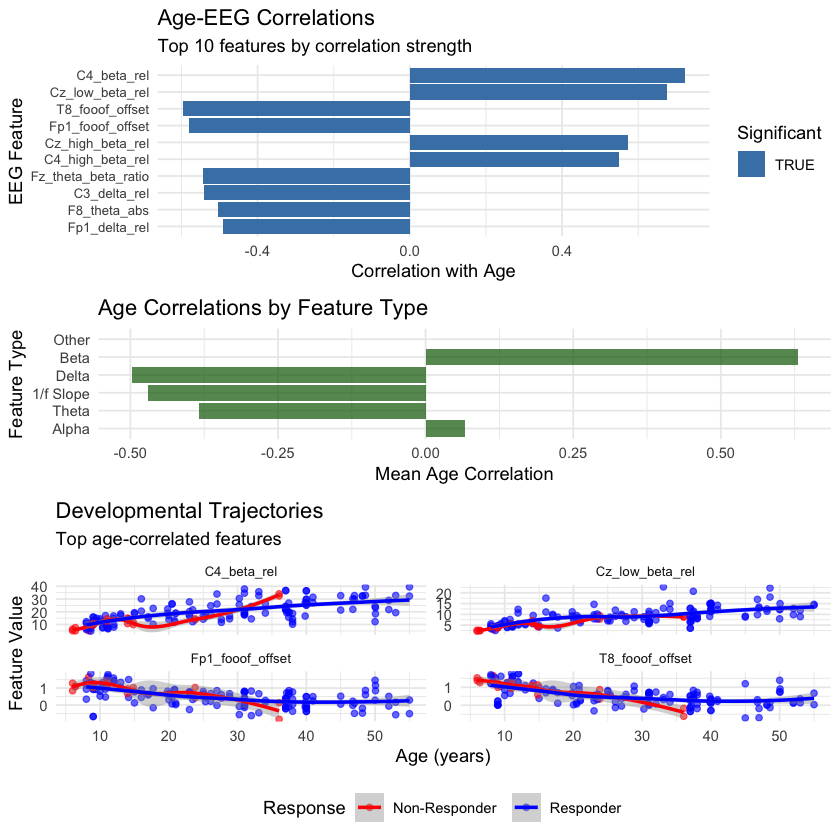

In [196]:
# For visualization, use top 15 features to keep plots readable
top_15_for_plots <- head(boot_final_results$feature_stability$feature, 15)
age_plots <- create_age_analysis_plots(age_results, analysis_data, top_15_for_plots)

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


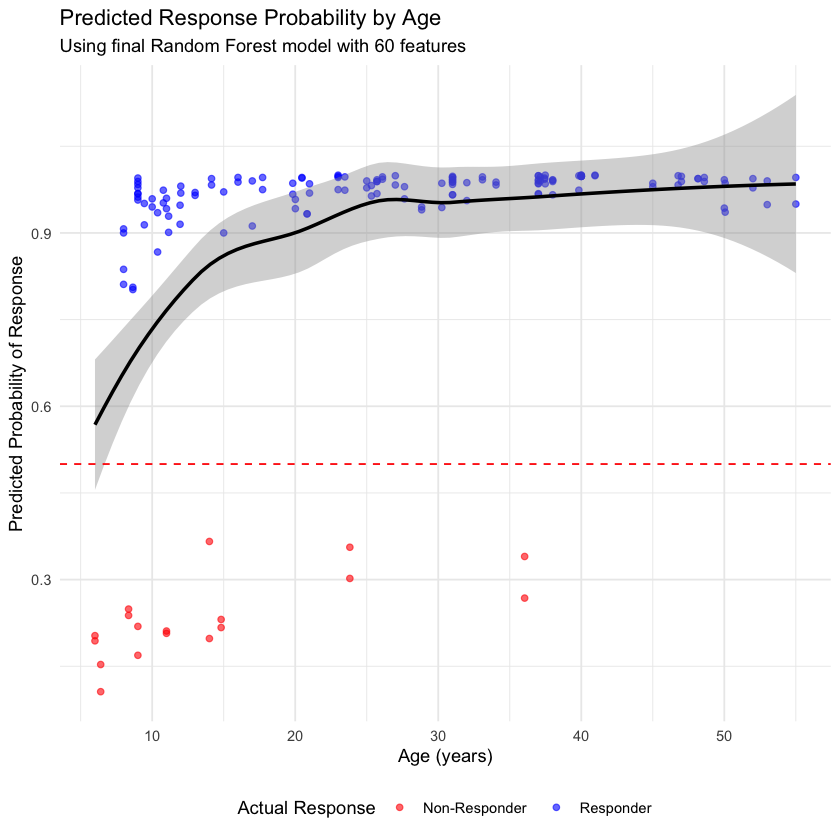

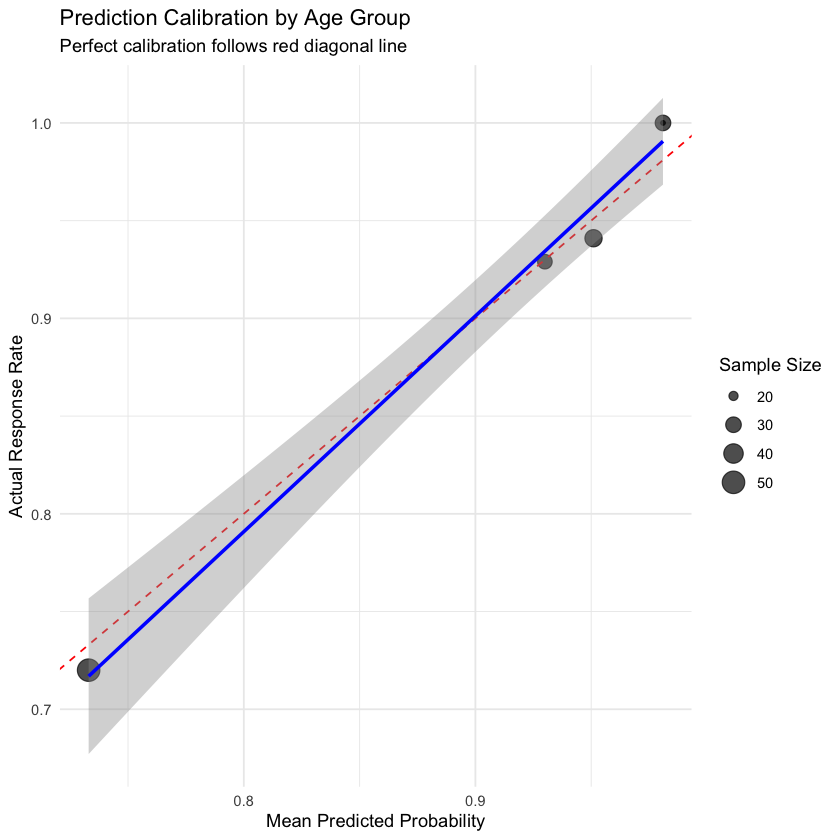

`geom_smooth()` using formula = 'y ~ x'
Warning message:
"Removed 16 rows containing non-finite outside the scale range
(`stat_smooth()`)."
Warning message:
"Removed 16 rows containing missing values or values outside the scale range
(`geom_point()`)."


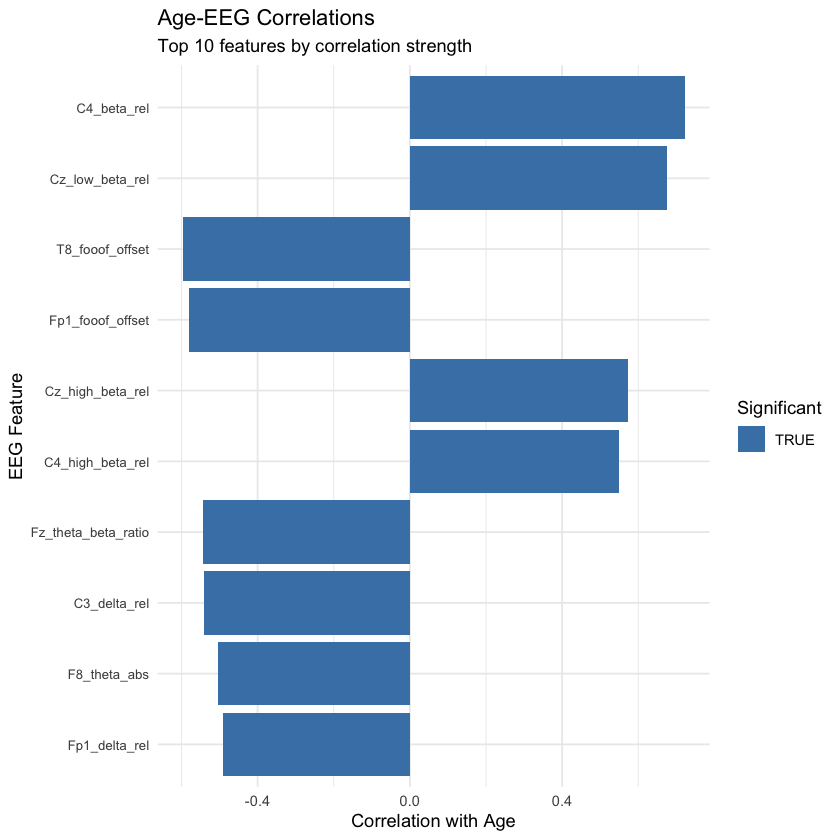

Age_Tertile,Sample_Size,Responders,Non_Responders,AUC,Sensitivity,Specificity,Optimal_Threshold,Age_Range
<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Youngest,52,38,14,1,1,1,0.802,6-16.7
Youngest,52,38,14,1,1,1,0.802,NA
Middle,52,50,2,1,1,1,0.912,16.7-34.7
Middle,52,50,2,1,1,1,0.912,NA
Oldest,52,50,2,1,1,1,0.936,34.7-55
Oldest,52,50,2,1,1,1,0.936,NA


,Feature,Overall_r,Overall_p,Responder_r,Responder_p,NonResponder_r,NonResponder_p,Significant_Overall,Strong_Correlation
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>
5,C4_beta_rel,0.722,0.0000,0.679,0.0000,0.925,0.0000,TRUE,TRUE
9,Cz_low_beta_rel,0.675,0.0000,0.627,0.0000,0.891,0.0000,TRUE,TRUE
14,T8_fooof_offset,-0.597,0.0000,-0.535,0.0000,-0.927,0.0000,TRUE,TRUE
19,Fp1_fooof_offset,-0.579,0.0000,-0.527,0.0000,-0.827,0.0000,TRUE,TRUE
1,Cz_high_beta_rel,0.572,0.0000,0.536,0.0000,0.913,0.0000,TRUE,TRUE
7,C4_high_beta_rel,0.550,0.0000,0.491,0.0000,0.896,0.0000,TRUE,TRUE
6,Fz_theta_beta_ratio,-0.544,0.0000,-0.490,0.0000,-0.657,0.0031,TRUE,TRUE
13,C3_delta_rel,-0.540,0.0000,-0.477,0.0000,-0.760,0.0003,TRUE,TRUE
17,F8_theta_abs,-0.504,0.0000,-0.448,0.0000,-0.686,0.0017,TRUE,TRUE


$age_effect_strength
[1] "age_dependent"

$age_performance_pattern
[1] "age_universal"

$strong_correlations
[1] 15

$total_features
[1] 20

$best_age_group
[1] "Youngest"

$worst_age_group
[1] "Youngest"

age_group_detailed,n,mean_age,actual_response_rate,predicted_response_rate,mean_predicted_prob,accuracy,calibration_diff
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Youngest,50,10.4,0.720,0.720,0.733,1,0.013
Young,28,21.2,0.929,0.929,0.930,1,0.001
Middle,30,29.7,1.000,1.000,0.981,1,0.019
Older,34,38.7,0.941,0.941,0.951,1,0.009
Oldest,18,50.1,1.000,1.000,0.981,1,0.019


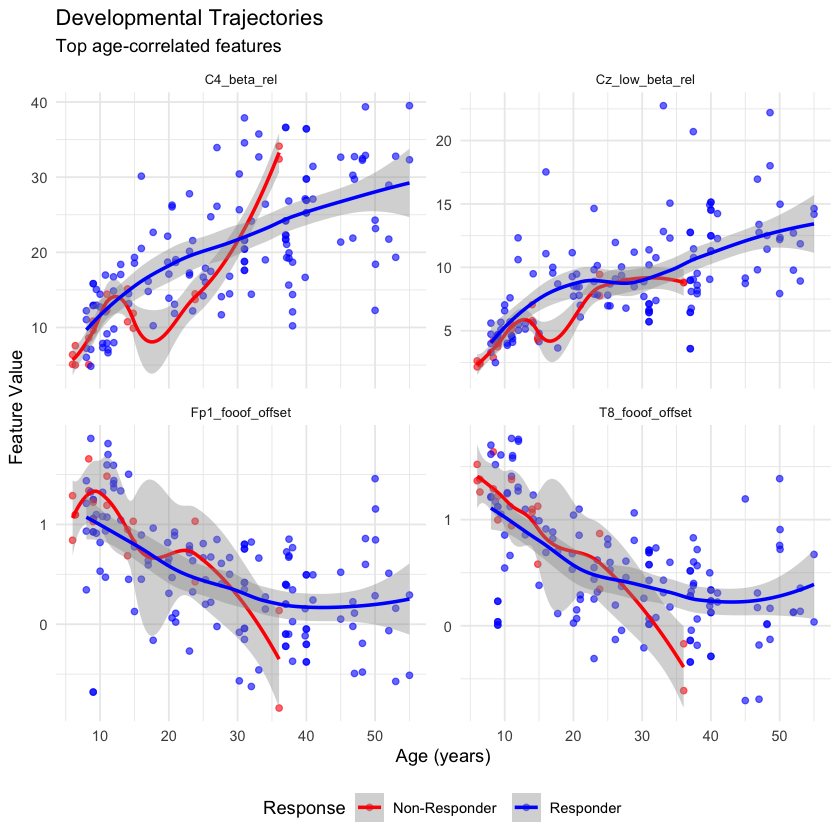

In [197]:
# View key plots
print(pred_analysis$age_prediction_plot)
print(pred_analysis$calibration_plot)
print(age_plots$correlation_plot)
print(age_plots$trajectory_plot)

# Access detailed results
age_results$age_performance  # Performance by age tertile
age_results$age_correlations  # Age-EEG correlations
age_results$conclusions  # Clinical conclusions
pred_analysis$age_pred_analysis  # Prediction patterns by age

In [198]:

top_features <- head(boot_final_results$feature_stability$feature, 60)  # Your top features
eeg_features_only <- top_features[!grepl("age|education|gender|sessions", top_features, ignore.case = TRUE)]
eeg_features_available <- intersect(eeg_features_only, names(analysis_data))
# eeg_features_available

developmental_patterns <- age_results
data <- analysis_data

In [199]:
developmental_patterns$developmental_patterns

age_tertile,Responder,Cz_high_beta_rel,Cz_theta_rel,T8_theta_rel,T8_theta_beta_ratio,C4_beta_rel,Fz_theta_beta_ratio,C4_high_beta_rel,Fp1_theta_rel,...,Fp1_theta_beta_ratio,Fp2_fooof_offset,Cz_delta_abs,F3_low_beta_rel,T8_fooof_exponent,C4_fooof_r2,CP4_fooof_r2,O2_fooof_exponent,P3_alpha_peak_power,n
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
Youngest,0,3.029689,30.27866,23.59944,2.0775319,9.472174,3.4386711,4.139585,21.01145,...,1.6943474,1.1204441,88.325413,6.436629,1.2027140,0.9867579,0.9875280,1.4833333,33.919694,14
Youngest,1,3.801177,25.29126,17.14132,1.2150235,12.589491,2.1785987,5.772088,16.51631,...,1.1995247,1.0570301,75.977195,7.892913,0.9302026,0.9599900,0.9772966,1.2960565,34.376896,38
Middle,0,7.003857,30.79624,19.33426,1.0844800,14.097924,1.2064211,6.168606,18.81173,...,0.8414970,0.4610317,17.705736,12.038952,1.1805343,0.9776176,0.9846272,1.3260584,20.618014,2
Middle,1,10.101439,22.78328,15.76178,0.7167135,20.569771,1.2620998,10.679716,17.96186,...,0.8351818,0.4386717,17.862688,10.730354,0.8553491,0.9578753,0.9664039,1.0179916,11.790253,50
Oldest,0,26.427166,23.82057,11.74701,0.3305144,33.268113,0.8713343,21.246301,19.28080,...,0.5964396,-0.4133584,7.203175,11.424586,0.2745888,0.9627256,0.9691790,0.6277751,1.581532,2
Oldest,1,10.246463,17.27619,12.96239,0.5192759,25.686707,0.9170148,12.280818,14.16284,...,0.5685506,0.2346732,18.340977,12.101269,0.6659931,0.9307551,0.9567989,0.7285701,16.298462,50


In [200]:
features_to_plot <- intersect(eeg_features_available, names(developmental_patterns))
features_to_plot


character(0)

In [201]:
    if(length(features_to_plot) > 0) {
      heatmap_data <- developmental_patterns %>%
        select(age_tertile, Responder, n, all_of(features_to_plot)) %>%
        mutate(Group = paste(age_tertile, ifelse(Responder == 1, "Responder", "Non-Responder"), sep = "_")) %>%
        select(-age_tertile, -Responder, -n) %>%
        pivot_longer(cols = all_of(features_to_plot), 
                     names_to = "Feature", values_to = "Mean_Value") %>%
        mutate(
          Age_Group = gsub("_.*", "", Group),
          Response_Group = gsub(".*_", "", Group),
          Age_Group = factor(Age_Group, levels = c("Youngest", "Middle", "Oldest")),
          Response_Group = factor(Response_Group, levels = c("Non-Responder", "Responder"))
        )
      
      p1 <- ggplot(heatmap_data, aes(x = Age_Group, y = Feature, fill = Mean_Value)) +
        geom_tile(color = "white", size = 0.5) +
        facet_wrap(~ Response_Group, ncol = 2) +
        scale_fill_gradient2(low = "blue", mid = "white", high = "red", 
                             midpoint = median(heatmap_data$Mean_Value, na.rm = TRUE),
                             name = "Mean\nValue") +
        labs(title = "Developmental Patterns by Response Group",
             subtitle = "EEG Feature Means Across Age Groups",
             x = "Age Group", y = "EEG Feature") +
        theme_minimal() +
        theme(axis.text.x = element_text(angle = 45, hjust = 1),
              axis.text.y = element_text(size = 9),
              plot.title = element_text(size = 14, face = "bold"),
              strip.text = element_text(size = 11, face = "bold"))
      
      print(p1)
    }

In [233]:
developmental_patterns

$age_breakdown
# A tibble: 4 x 6
  age_tertile Response_0 Response_1 Total Response_Rate Age_Range
  <fct>            <int>      <int> <int>         <dbl> <chr>    
1 Youngest            14         38    52          73.1 6-16.7   
2 Middle               2         50    52          96.2 16.7-34.7
3 Oldest               2         50    52          96.2 34.7-55  
4 NA                   0          4     4         100   NA       

$age_performance
  Age_Tertile Sample_Size Responders Non_Responders AUC Sensitivity Specificity
1    Youngest          52         38             14   1           1           1
2    Youngest          52         38             14   1           1           1
3      Middle          52         50              2   1           1           1
4      Middle          52         50              2   1           1           1
5      Oldest          52         50              2   1           1           1
6      Oldest          52         50              2   1           1           1
  Optimal_Threshold Age_Range
1             0.802    6-16.7
2             0.802      <NA>
3             0.912 16.7-34.7
4             0.912      <NA>
5             0.936   34.7-55
6             0.936      <NA>

$age_performance_conclusion
[1] "age_universal"

$age_correlations
               Feature Overall_r Overall_p Responder_r Responder_p
5          C4_beta_rel     0.722    0.0000       0.679      0.0000
9      Cz_low_beta_rel     0.675    0.0000       0.627      0.0000
14     T8_fooof_offset    -0.597    0.0000      -0.535      0.0000
19    Fp1_fooof_offset    -0.579    0.0000      -0.527      0.0000
1     Cz_high_beta_rel     0.572    0.0000       0.536      0.0000
7     C4_high_beta_rel     0.550    0.0000       0.491      0.0000
6  Fz_theta_beta_ratio    -0.544    0.0000      -0.490      0.0000
13        C3_delta_rel    -0.540    0.0000      -0.477      0.0000
17        F8_theta_abs    -0.504    0.0000      -0.448      0.0000
16       Fp1_delta_rel    -0.492    0.0000      -0.418      0.0000
10        F4_delta_abs    -0.463    0.0000      -0.464      0.0000
4  T8_theta_beta_ratio    -0.453    0.0000      -0.386      0.0000
2         Cz_theta_rel    -0.435    0.0000      -0.374      0.0000
15        T7_theta_rel    -0.361    0.0000      -0.302      0.0003
3         T8_theta_rel    -0.325    0.0000      -0.225      0.0080
12        F3_theta_rel    -0.254    0.0014      -0.187      0.0283
11        CP3_fooof_r2    -0.233    0.0035      -0.204      0.0165
8        Fp1_theta_rel    -0.198    0.0131      -0.142      0.0978
20   Pz_fooof_alpha_cf     0.191    0.0212       0.134      0.1267
18  CPz_fooof_alpha_cf    -0.059    0.4859      -0.078      0.3876
   NonResponder_r NonResponder_p Significant_Overall Strong_Correlation
5           0.925         0.0000                TRUE               TRUE
9           0.891         0.0000                TRUE               TRUE
14         -0.927         0.0000                TRUE               TRUE
19         -0.827         0.0000                TRUE               TRUE
1           0.913         0.0000                TRUE               TRUE
7           0.896         0.0000                TRUE               TRUE
6          -0.657         0.0031                TRUE               TRUE
13         -0.760         0.0003                TRUE               TRUE
17         -0.686         0.0017                TRUE               TRUE
16         -0.776         0.0002                TRUE               TRUE
10         -0.751         0.0003                TRUE               TRUE
4          -0.557         0.0162                TRUE               TRUE
2          -0.379         0.1208                TRUE               TRUE
15         -0.473         0.0476                TRUE               TRUE
3          -0.595         0.0092                TRUE               TRUE
12         -0.233         0.3519                TRUE              FALSE
11         -0.761         0.0002                TRUE              FALSE
8          -

In [234]:
# Load required libraries
library(ggplot2)
library(dplyr)
library(tidyr)
library(RColorBrewer)
library(gridExtra)

# ============================================================================
# VISUALIZATION FOR ANALYSIS 3: DEVELOPMENTAL PATTERNS BY RESPONSE GROUP
# ============================================================================

visualize_developmental_patterns <- function(developmental_patterns, data, eeg_features_available) {
  
  cat("Creating Developmental Patterns Visualizations...\n")
  
  if(nrow(developmental_patterns) > 0) {
    
    # PLOT 1: Heatmap of developmental patterns
    # Prepare data for heatmap - take first 8 features for clarity
    features_to_plot <- intersect(eeg_features_available[1:8], names(developmental_patterns))
    
    if(length(features_to_plot) > 0) {
      heatmap_data <- developmental_patterns %>%
        select(age_tertile, Responder, n, all_of(features_to_plot)) %>%
        mutate(Group = paste(age_tertile, ifelse(Responder == 1, "Responder", "Non-Responder"), sep = "_")) %>%
        select(-age_tertile, -Responder, -n) %>%
        pivot_longer(cols = all_of(features_to_plot), 
                     names_to = "Feature", values_to = "Mean_Value") %>%
        mutate(
          Age_Group = gsub("_.*", "", Group),
          Response_Group = gsub(".*_", "", Group),
          Age_Group = factor(Age_Group, levels = c("Youngest", "Middle", "Oldest")),
          Response_Group = factor(Response_Group, levels = c("Non-Responder", "Responder"))
        )
      heatmap_data <- heatmap_data %>%
        filter(Feature %in% c("F4_delta_abs", "C3_delta_rel", "Fz_theta_beta_ratio", "T8_theta_beta_ratio",
              "Cz_high_beta_rel", "C4_high_beta_rel", "C4_beta_rel", "Cz_low_beta_rel"))
      p1 <- ggplot(heatmap_data, aes(x = Age_Group, y = Feature, fill = Mean_Value)) +
        geom_tile(color = "white", size = 0.5) +
        facet_wrap(~ Response_Group, ncol = 2) +
        scale_fill_gradient2(low = "blue", mid = "white", high = "red", 
                             midpoint = median(heatmap_data$Mean_Value, na.rm = TRUE),
                             name = "Mean\nValue") +
        labs(title = "Developmental Patterns by Response Group",
             subtitle = "EEG Feature Means Across Age Groups",
             x = "Age Group", y = "EEG Feature") +
        theme_minimal() +
        theme(axis.text.x = element_text(angle = 45, hjust = 1),
              axis.text.y = element_text(size = 9),
              plot.title = element_text(size = 14, face = "bold"),
              strip.text = element_text(size = 11, face = "bold"))
      
      print(p1)
    }
    
    # PLOT 2: Line plots showing developmental trajectories
    if(length(features_to_plot) >= 4) {
      # Select top 4 features for line plots
      line_features <- features_to_plot[1:4]
      line_features <- c("F4_delta_abs", "C3_delta_rel", "Fz_theta_beta_ratio", "T8_theta_beta_ratio",
              "Cz_high_beta_rel", "C4_high_beta_rel", "C4_beta_rel", "Cz_low_beta_rel")
      
      line_data <- developmental_patterns %>%
        select(age_tertile, Responder, n, all_of(line_features)) %>%
        pivot_longer(cols = all_of(line_features), 
                     names_to = "Feature", values_to = "Mean_Value") %>%
        mutate(
          Response_Group = ifelse(Responder == 1, "Responder", "Non-Responder"),
          Age_Numeric = case_when(
            age_tertile == "Youngest" ~ 1,
            age_tertile == "Middle" ~ 2,
            age_tertile == "Oldest" ~ 3
          )
        )
      
      p2 <- ggplot(line_data, aes(x = Age_Numeric, y = Mean_Value, 
                                  color = Response_Group, linetype = Response_Group)) +
        geom_line(size = 1.2, alpha = 0.8) +
        geom_point(size = 3, alpha = 0.8) +
        facet_wrap(~ Feature, scales = "free_y", ncol = 2) +
        scale_x_continuous(breaks = c(1, 2, 3), 
                           labels = c("Youngest", "Middle", "Oldest")) +
        scale_color_manual(values = c("Responder" = "blue", "Non-Responder" = "red")) +
        scale_linetype_manual(values = c("Responder" = "solid", "Non-Responder" = "dashed")) +
        labs(title = "Developmental Trajectories by Response Group",
             subtitle = "How EEG features change with age for responders vs non-responders",
             x = "Age Group", y = "Mean Feature Value",
             color = "Group", linetype = "Group") +
        theme_minimal() +
        theme(plot.title = element_text(size = 14, face = "bold"),
              legend.position = "bottom",
              strip.text = element_text(size = 10, face = "bold"))
      
      print(p2)
    }
  
    
    return(list(
      heatmap_plot = if(exists("p1")) p1 else NULL,
      trajectory_plot = if(exists("p2")) p2 else NULL,
      difference_plot = if(exists("p3")) p3 else NULL
    ))
    
  } else {
    cat("No developmental patterns data available for visualization\n")
    return(NULL)
  }
}

# ============================================================================
# VISUALIZATION FOR ANALYSIS 4: FEATURE PATTERNS BY AGE
# ============================================================================

visualize_feature_age_patterns <- function(feature_age_patterns, data, eeg_features_available) {
  
  cat("Creating Feature Age Patterns Visualizations...\n")
  
  if(nrow(feature_age_patterns) > 0) {
    
    # PLOT 1: Age Variability Bar Chart
    top_10_variable <- head(feature_age_patterns, 20)
    print(dim(top_10_variable))
    
    p1 <- ggplot(top_10_variable, aes(x = reorder(Feature, Age_Variability), y = Age_Variability)) +
      geom_col(fill = "steelblue", alpha = 0.7) +
      coord_flip() +
      labs(title = "Most Age-Variable EEG Features",
           subtitle = "Coefficient of Variation across Age Groups",
           x = "EEG Feature", y = "Age Variability (CV)") +
      theme_minimal() +
      theme(plot.title = element_text(size = 14, face = "bold"),
            axis.text.y = element_text(size = 10))
    
    print(p1)
    
    # PLOT 2: Heatmap of feature values across age groups
    heatmap_data <- feature_age_patterns %>%
      select(Feature, Youngest_Mean, Middle_Mean, Oldest_Mean) %>%
      pivot_longer(cols = c(Youngest_Mean, Middle_Mean, Oldest_Mean), 
                   names_to = "Age_Group", values_to = "Mean_Value") %>%
      mutate(Age_Group = factor(Age_Group, 
                               levels = c("Youngest_Mean", "Middle_Mean", "Oldest_Mean"),
                               labels = c("Youngest", "Middle", "Oldest")))
    
    p2 <- ggplot(heatmap_data, aes(x = Age_Group, y = reorder(Feature, Mean_Value), fill = Mean_Value)) +
      geom_tile(color = "white", size = 0.5) +
      scale_fill_gradient2(low = "blue", mid = "white", high = "red", 
                           midpoint = median(heatmap_data$Mean_Value, na.rm = TRUE),
                           name = "Mean\nValue") +
      labs(title = "EEG Feature Values Across Age Groups",
           subtitle = "Top 12 Most Age-Variable Features",
           x = "Age Group", y = "EEG Feature") +
      theme_minimal() +
      theme(axis.text.y = element_text(size = 9),
            axis.text.x = element_text(size = 11),
            plot.title = element_text(size = 14, face = "bold")) +
      coord_fixed(ratio = 0.3)
    
    print(p2)
    
    # PLOT 3: Line plot showing age trends
    line_data <- heatmap_data %>%
      mutate(Age_Numeric = case_when(
        Age_Group == "Youngest" ~ 1,
        Age_Group == "Middle" ~ 2,
        Age_Group == "Oldest" ~ 3
      ))
    
    # Take top 8 features for cleaner line plot
    top_8_features <- head(feature_age_patterns$Feature, 8)
    line_data_filtered <- line_data %>% filter(Feature %in% top_8_features)
    
    p3 <- ggplot(line_data_filtered, aes(x = Age_Numeric, y = Mean_Value, color = Feature)) +
      geom_line(size = 1.2, alpha = 0.8) +
      geom_point(size = 3, alpha = 0.8) +
      scale_x_continuous(breaks = c(1, 2, 3), 
                         labels = c("Youngest", "Middle", "Oldest")) +
      scale_color_brewer(type = "qual", palette = "Set3") +
      labs(title = "Age-Related Changes in EEG Features",
           subtitle = "Mean values across age tertiles",
           x = "Age Group", y = "Mean Feature Value",
           color = "EEG Feature") +
      theme_minimal() +
      theme(plot.title = element_text(size = 14, face = "bold"),
            legend.position = "bottom") +
      guides(color = guide_legend(ncol = 2))
    
    print(p3)
    
    # PLOT 4: Scatter plot matrix for top features if we have individual data
    if(exists("data") && length(intersect(top_8_features, names(data))) >= 4) {
      
      available_features <- intersect(head(top_8_features, 4), names(data))
      
      if("age_tertile" %in% names(data) && length(available_features) >= 4) {
        
        scatter_data <- data %>%
          select(age, age_tertile, all_of(available_features)) %>%
          pivot_longer(cols = all_of(available_features), 
                       names_to = "Feature", values_to = "Value") %>%
          filter(!is.na(Value) & !is.na(age_tertile))
        
        p4 <- ggplot(scatter_data, aes(x = age, y = Value, color = age_tertile)) +
          geom_point(alpha = 0.6, size = 1.5) +
          geom_smooth(method = "loess", se = TRUE, alpha = 0.3) +
          facet_wrap(~ Feature, scales = "free_y", ncol = 2) +
          scale_color_brewer(type = "qual", palette = "Set1", name = "Age Group") +
          labs(title = "Individual Data Points: Age vs EEG Features",
               subtitle = "Showing continuous age relationships",
               x = "Age (years)", y = "Feature Value") +
          theme_minimal() +
          theme(plot.title = element_text(size = 14, face = "bold"),
                legend.position = "bottom",
                strip.text = element_text(size = 10, face = "bold"))
        
        # print(p4)
      }
    }
    
    # PLOT 5: Summary statistics table as a plot
    summary_stats <- feature_age_patterns %>%
      head(10) %>%
      mutate(
        Range = Oldest_Mean - Youngest_Mean,
        Direction = ifelse(Range > 0, "Increases", "Decreases"),
        Magnitude = case_when(
          Age_Variability > 0.3 ~ "High",
          Age_Variability > 0.15 ~ "Moderate",
          TRUE ~ "Low"
        )
      ) %>%
      select(Feature, Age_Variability, Direction, Range, Magnitude)
    
    # Convert to a visual table
    p5 <- ggplot(summary_stats, aes(x = Age_Variability, y = reorder(Feature, Age_Variability))) +
      geom_col(aes(fill = Direction), alpha = 0.7) +
      geom_text(aes(label = paste0("CV=", round(Age_Variability, 3))), 
                hjust = -0.1, size = 3) +
      scale_fill_manual(values = c("Increases" = "coral", "Decreases" = "lightblue")) +
      labs(title = "Age-Related Feature Changes Summary",
           subtitle = "Direction and magnitude of changes from youngest to oldest",
           x = "Age Variability (Coefficient of Variation)", 
           y = "EEG Feature",
           fill = "Age Trend") +
      theme_minimal() +
      theme(plot.title = element_text(size = 14, face = "bold"),
            axis.text.y = element_text(size = 9))
    
    # print(p5)
    
    return(list(
      variability_plot = p1,
      heatmap_plot = p2,
      line_plot = p3,
      scatter_plot = if(exists("p4")) p4 else NULL,
      summary_plot = p5
    ))
    
  } else {
    cat("No feature age patterns data available for visualization\n")
    return(NULL)
  }
}

# ============================================================================
# COMBINED VISUALIZATION FUNCTION
# ============================================================================

create_comprehensive_age_visualizations <- function(age_analysis_results, data, eeg_features_available) {
  
  cat("Creating comprehensive age analysis visualizations...\n")
  
  # Visualize Analysis 3: Developmental Patterns
  if(!is.null(age_analysis_results$developmental_patterns)) {
    cat("\n--- ANALYSIS 3 VISUALIZATIONS ---\n")
    dev_plots <- visualize_developmental_patterns(
      age_analysis_results$developmental_patterns, 
      data, 
      eeg_features_available
    )
  }
  
  # Visualize Analysis 4: Feature Age Patterns
  if(!is.null(age_analysis_results$feature_age_patterns)) {
    cat("\n--- ANALYSIS 4 VISUALIZATIONS ---\n")
    age_plots <- visualize_feature_age_patterns(
      age_analysis_results$feature_age_patterns, 
      data, 
      eeg_features_available
    )
  }
  
  return(list(
    developmental_plots = if(exists("dev_plots")) dev_plots else NULL,
    age_pattern_plots = if(exists("age_plots")) age_plots else NULL
  ))
}

Creating comprehensive age analysis visualizations...

--- ANALYSIS 3 VISUALIZATIONS ---
Creating Developmental Patterns Visualizations...


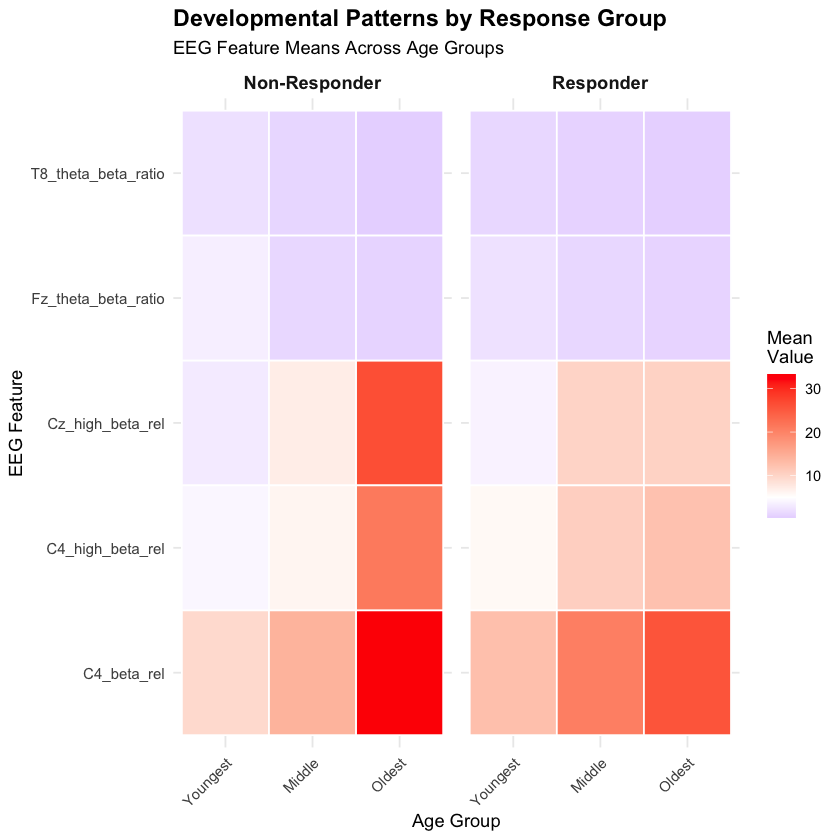


--- ANALYSIS 4 VISUALIZATIONS ---
Creating Feature Age Patterns Visualizations...
[1] 20  5


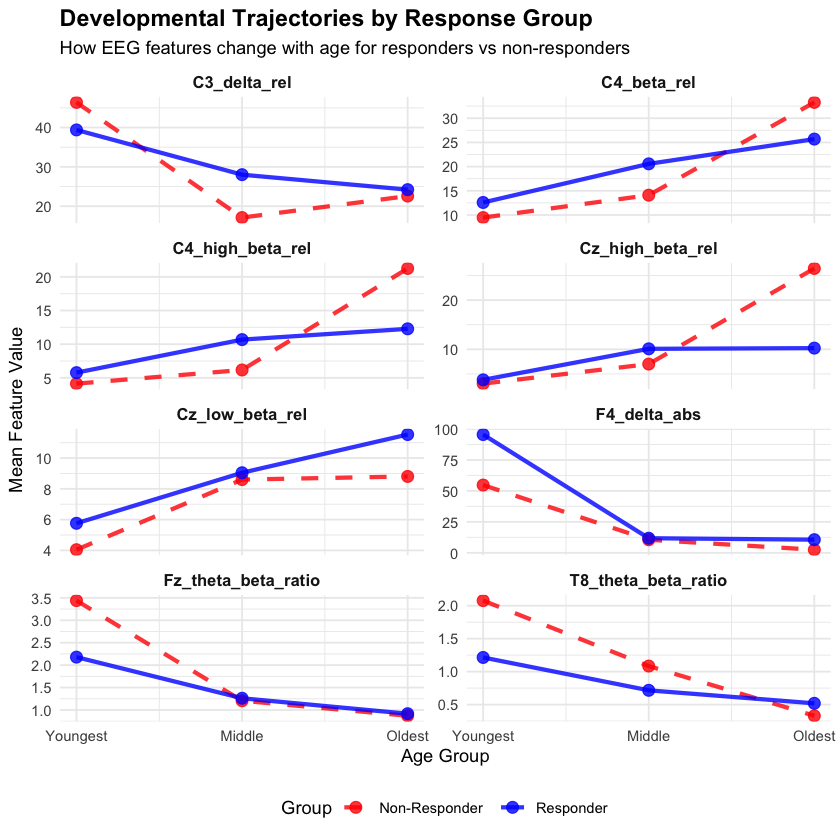

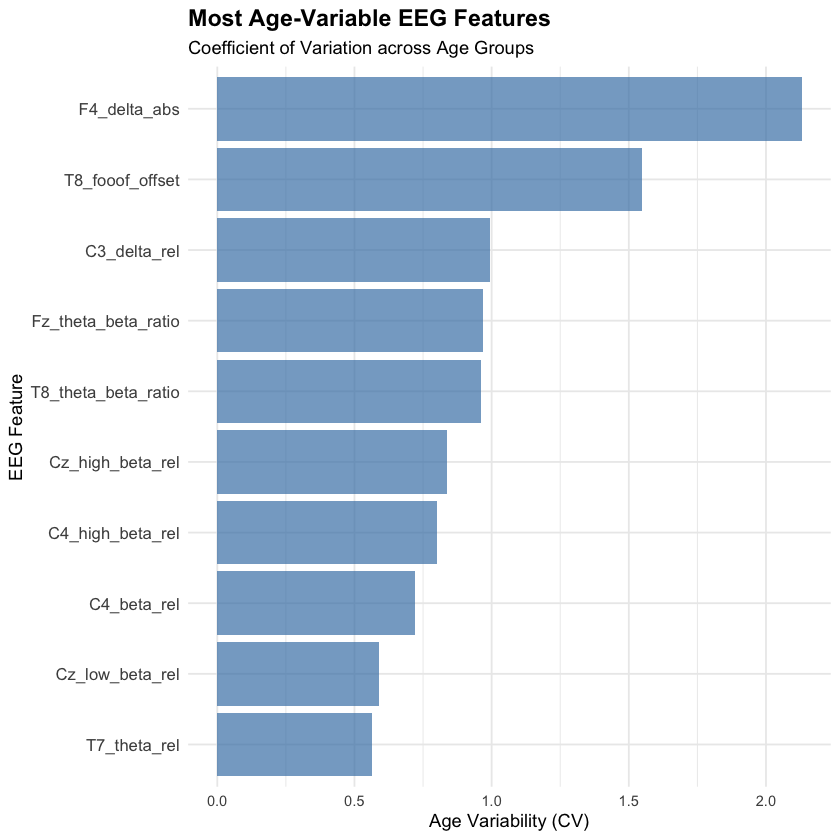

Warning message:
"Removed 4 rows containing missing values or values outside the scale range
(`geom_line()`)."
Warning message:
"Removed 12 rows containing missing values or values outside the scale range
(`geom_point()`)."


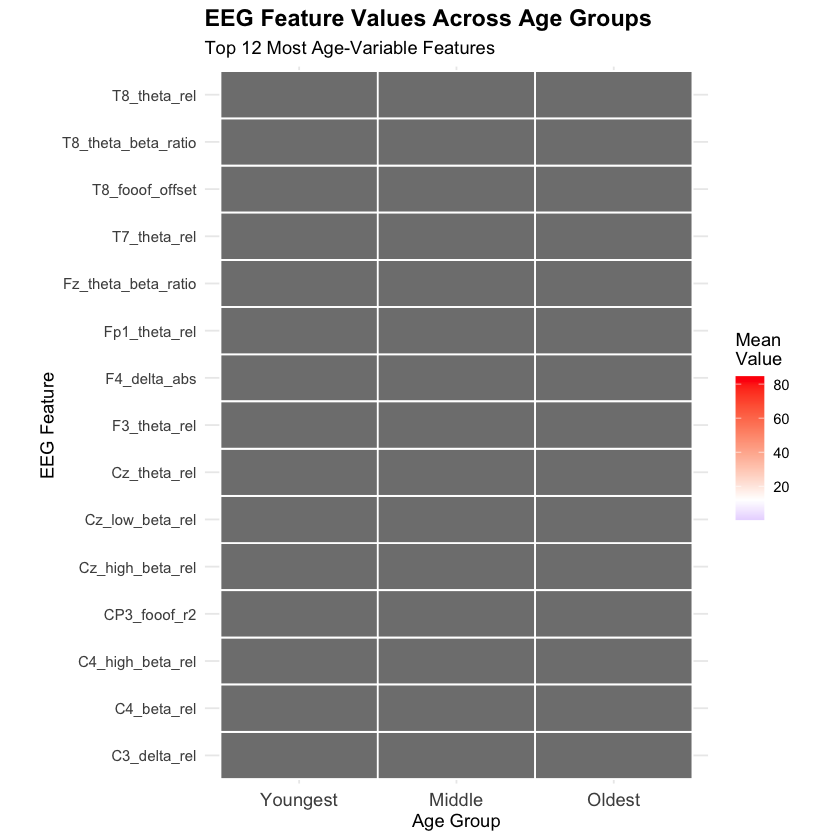

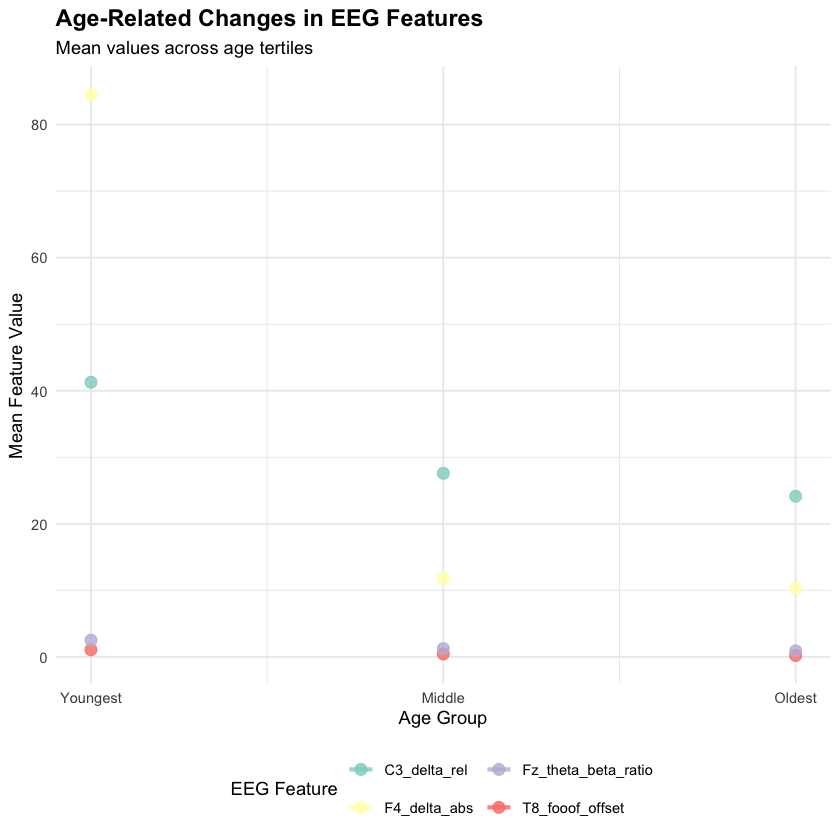

In [235]:
top_features <- head(boot_final_results$feature_stability$feature, 60)  # Your top features
eeg_features_only <- top_features[!grepl("age|education|gender|sessions", top_features, ignore.case = TRUE)]
eeg_features_available <- intersect(eeg_features_only, names(analysis_data))
# eeg_features_available

# developmental_patterns, data, eeg_features_available
all_plots <- create_comprehensive_age_visualizations(age_results, analysis_data, eeg_features_available)


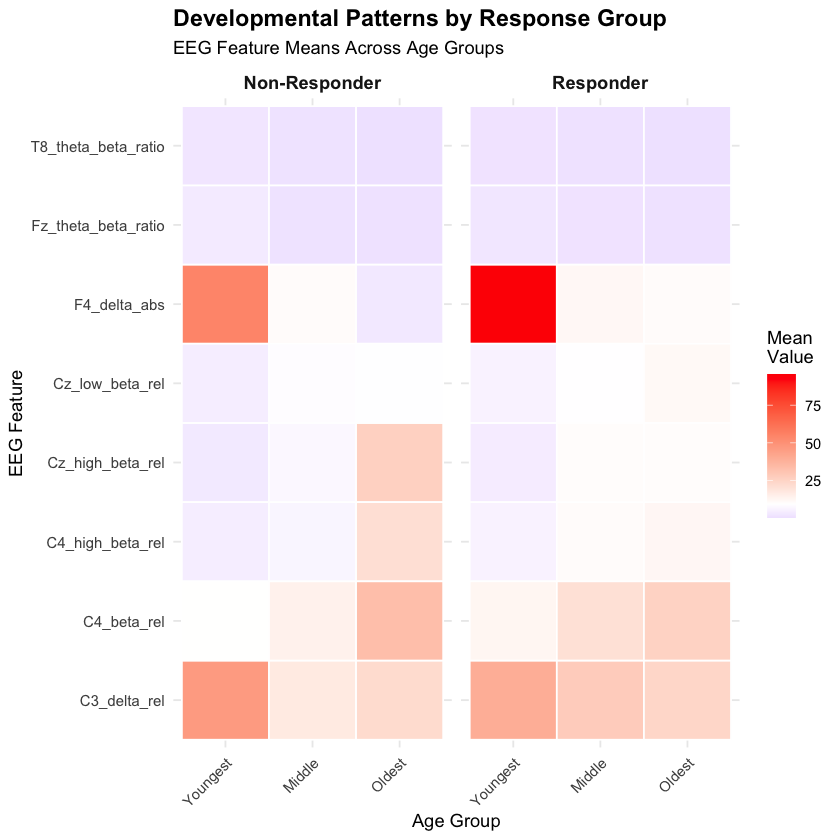

In [237]:
library(ggplot2)
library(dplyr)
library(tidyr)

plot_developmental_patterns_heatmap <- function(developmental_patterns, features_to_plot) {
  # Only keep features that exist in the data
  features_to_plot <- intersect(features_to_plot, names(developmental_patterns))
  if(length(features_to_plot) == 0) {
    stop("No valid features to plot.")
  }
  
  heatmap_data <- developmental_patterns %>%
    select(age_tertile, Responder, n, all_of(features_to_plot)) %>%
    mutate(Group = paste(age_tertile, ifelse(Responder == 1, "Responder", "Non-Responder"), sep = "_")) %>%
    select(-age_tertile, -Responder, -n) %>%
    pivot_longer(cols = all_of(features_to_plot), 
                 names_to = "Feature", values_to = "Mean_Value") %>%
    mutate(
      Age_Group = gsub("_.*", "", Group),
      Response_Group = gsub(".*_", "", Group),
      Age_Group = factor(Age_Group, levels = c("Youngest", "Middle", "Oldest")),
      Response_Group = factor(Response_Group, levels = c("Non-Responder", "Responder"))
    )
  
  ggplot(heatmap_data, aes(x = Age_Group, y = Feature, fill = Mean_Value)) +
    geom_tile(color = "white", size = 0.5) +
    facet_wrap(~ Response_Group, ncol = 2) +
    scale_fill_gradient2(low = "blue", mid = "white", high = "red", 
                         midpoint = median(heatmap_data$Mean_Value, na.rm = TRUE),
                         name = "Mean\nValue") +
    labs(title = "Developmental Patterns by Response Group",
         subtitle = "EEG Feature Means Across Age Groups",
         x = "Age Group", y = "EEG Feature") +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1),
          axis.text.y = element_text(size = 9),
          plot.title = element_text(size = 14, face = "bold"),
          strip.text = element_text(size = 11, face = "bold"))
}

# Example usage:
# Choose the features you want to show:
features_to_show <- c("F4_delta_abs", "C3_delta_rel", "Fz_theta_beta_ratio", "T8_theta_beta_ratio",
              "Cz_high_beta_rel", "C4_high_beta_rel", "C4_beta_rel", "Cz_low_beta_rel")
plot_developmental_patterns_heatmap(developmental_patterns$developmental_patterns, features_to_show)

In [247]:
age_tertiles <- quantile(df$age, probs = c(0, 1/3, 2/3, 1), na.rm = TRUE)

# Add age_tertile column to df
df <- df %>%
  mutate(age_tertile = cut(age, breaks = age_tertiles, 
                           labels = c("Youngest", "Middle", "Oldest"), include.lowest = TRUE))

# Check distribution
table(df$age_tertile, df$Responder)

          
            0  1
  Youngest 14 40
  Middle    4 48
  Oldest    0 50

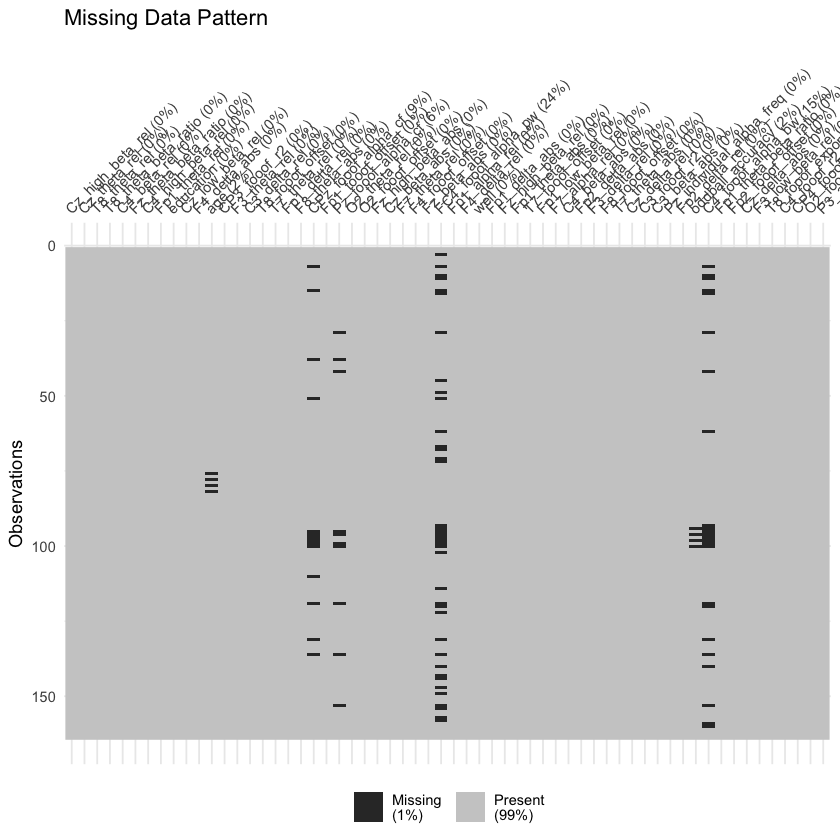

In [244]:
# Install naniar if not already installed
if (!requireNamespace("naniar", quietly = TRUE)) install.packages("naniar")
library(naniar)

# Visualize missing data pattern
vis_miss(df %>% select(top_60_features)) + ggtitle("Missing Data Pattern")

In [248]:
cat("Youngest:", round(age_tertiles[1],1), "-", round(age_tertiles[2],1), "\n")
cat("Middle:", round(age_tertiles[2],1), "-", round(age_tertiles[3],1), "\n")
cat("Oldest:", round(age_tertiles[3],1), "-", round(age_tertiles[4],1), "\n")

Youngest: 6 - 17 
Middle: 17 - 36 
Oldest: 36 - 55 


In [267]:
analysis_data <- analysis_data %>% 
    mutate(age_tertile = cut(age, breaks = age_tertiles, 
    labels = c("Youngest", "Middle", "Oldest"), include.lowest = TRUE))

In [268]:
age_group

[1] "Oldest"

In [ ]:
t_test_results

adj_p
<dbl>
